# Prueba 1

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def __preprocesing(img):
    # 1. Escala de grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Binarización con adaptive threshold
    thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, blockSize=15, C=10)

    # 3. Encontrar contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 4. Dibujar contornos sobre una copia de la imagen original
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0,255,0), 2)  # color verde, grosor 2

    return img_contours


def __preprocesing_2(img):
    # 1. Escala de grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Binarización con adaptive threshold
    thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, blockSize=15, C=10)

    # 3. Encontrar contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 4. Crear imagen negra y dibujar solo los contornos en blanco
    contour_img = np.zeros_like(img_gray)  # imagen negra
    cv2.drawContours(contour_img, contours, -1, 255, 2)  # blanco, grosor 2

    return contour_img

def preprocesing(img):
    # 1. Escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Reducción de ruido
    blurred = cv2.GaussianBlur(gray, (5,5), 0)

    # 3. Umbralización (Threshold)
    thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # 4. Detección de contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 5. Corrección de inclinación
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = gray.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    corrected = cv2.warpAffine(thresh, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return corrected


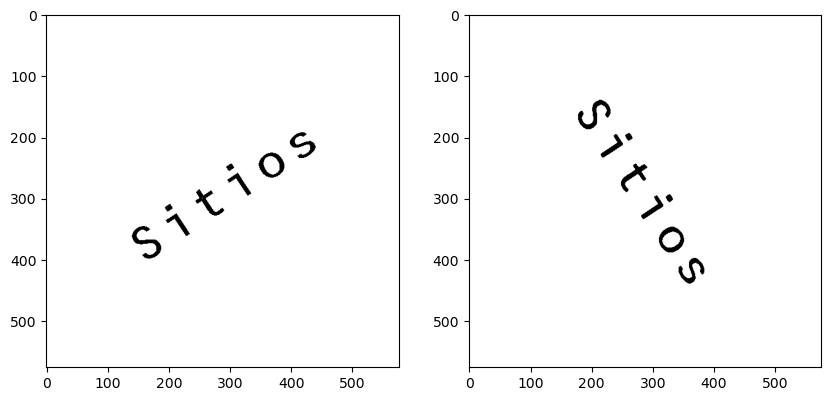

In [ ]:
# img = cv2.imread('test_ocr_char/A/1248.png')
img = cv2.imread('test_ocr_words_plain/0449.png')

img_contours = preprocesing(img)

# print(img_contours)
# plt.imshow(img_contours)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[1].imshow(img_contours, cmap='gray')

---

---

# Prueba 2

El modelo entrenado detecta caracteres con una precisión del 97%

No tiene:
- Detección de palabras
- Detección de posición de caracteres

In [28]:
import os
import matplotlib.pyplot as plt

import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [29]:
def cargar_y_etiquetar_imagenes_cv2(ruta_directorio, extensiones_validas={".jpg", ".jpeg", ".png"}):
    """
    Carga y etiqueta imágenes con OpenCV para entrenamiento OCR.
    Devuelve lista de tuplas (imagen_cv2, etiqueta)
    """
    datos = []

    for root, _, files in os.walk(ruta_directorio):
        etiqueta = os.path.basename(root)

        for archivo in files:
            extension = os.path.splitext(archivo)[1].lower()
            if extension in extensiones_validas:
                ruta_imagen = os.path.join(root, archivo)
                imagen = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
                if imagen is not None:
                    datos.append((imagen, etiqueta))
                else:
                    print(f"Error al cargar imagen: {ruta_imagen}")
    
    return datos

def preprocesar_imagen_cv2(imagen_cv2, size=(32, 32)):
    """
    Preprocesa una imagen usando OpenCV: escala de grises, binarización adaptativa,
    contorno más grande y redimensionado.
    """
    gris = cv2.cvtColor(imagen_cv2, cv2.COLOR_BGR2GRAY)

    # Binarización adaptativa
    binaria = cv2.adaptiveThreshold(gris, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 2)

    # Contornos
    contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contornos:
        roi = cv2.resize(binaria, size)
    else:
        contorno_principal = max(contornos, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contorno_principal)
        recorte = binaria[y:y+h, x:x+w]
        roi = cv2.resize(recorte, size)

    return roi.flatten()

def entrenar_ocr_cv2(datos):
    """
    Entrena OCR con imágenes OpenCV usando Random Forest.
    """
    X, y = [], []

    for imagen, etiqueta in datos:
        vector = preprocesar_imagen_cv2(imagen)
        X.append(vector)
        y.append(etiqueta)

    X = np.array(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    modelo = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return modelo


In [30]:
ruta = "E:/Practica_2_CV/Practica_2/Materiales_Practica2/train_ocr"
datos = cargar_y_etiquetar_imagenes_cv2(ruta)

Número de datos de entrenamiento:  112220


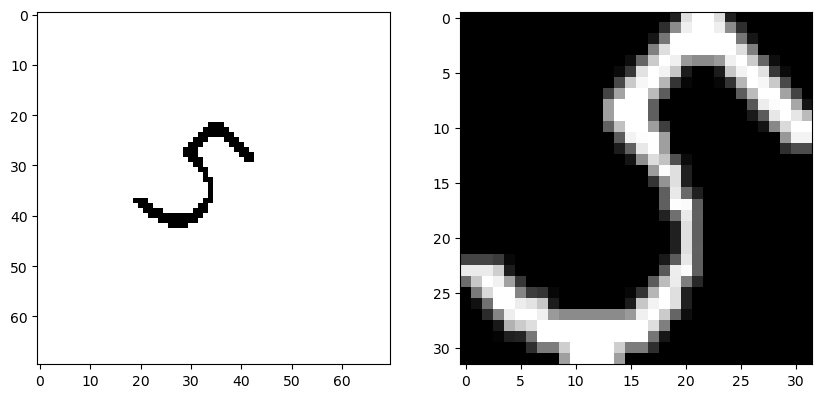

In [31]:
# Muestra de datos
print("Número de datos de entrenamiento: ", len(datos))

img, label = datos[10000]
procesada = preprocesar_imagen_cv2(img).reshape(32, 32)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[1].imshow(procesada, cmap='gray')

In [32]:
modelo = entrenar_ocr_cv2(datos)

Accuracy: 0.9690785956157547
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       383
           1       0.95      0.99      0.97       369
           2       1.00      0.99      0.99       353
           3       1.00      0.98      0.99       368
           4       0.98      0.98      0.98       381
           5       0.99      0.96      0.98       356
           6       0.98      0.99      0.98       365
           7       0.98      0.98      0.98       368
           8       1.00      1.00      1.00       354
           9       0.99      0.98      0.98       354
           A       0.98      0.96      0.97       373
           B       0.98      0.98      0.98       364
           C       0.96      0.99      0.97       342
           D       0.99      1.00      0.99       355
           E       0.99      0.97      0.98       365
           F       0.95      0.98      0.97       367
           G       1.00      0.98      0.99       36

In [33]:
def predecir_palabra(imagen_cv2, modelo, size=(32, 32)):
    """
    Detecta letras en una imagen de palabra y las reconoce con el modelo entrenado.

    Parámetros:
    - imagen_cv2: imagen de la palabra completa.
    - modelo: RandomForestClassifier entrenado.
    - size: tamaño de redimensionado para cada letra.

    Retorna:
    - texto reconocido (str)
    """
    gris = cv2.cvtColor(imagen_cv2, cv2.COLOR_BGR2GRAY)

    binaria = cv2.adaptiveThreshold(gris, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 2)

    # Encontrar contornos
    contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar contornos muy pequeños (ruido) y ordenarlos por posición X
    letras = []
    for c in contornos:
        x, y, w, h = cv2.boundingRect(c)
        if w * h > 50:  # Umbral para eliminar ruido
            letras.append((x, y, w, h))

    letras_ordenadas = sorted(letras, key=lambda b: b[0])  # Ordenar por posición X

    palabra = ""
    for (x, y, w, h) in letras_ordenadas:
        recorte = binaria[y:y+h, x:x+w]
        roi = cv2.resize(recorte, size).flatten()
        prediccion = modelo.predict([roi])[0]
        palabra += prediccion

    return palabra


---

# Prueba 3

El modelo entrenado detecta caracteres con una precisión del 97%

Tiene:
- Detección de palabras
- Detección de posición de caracteres

Falla:
- Confunde mayúsculas y minúsculas de las letras: (c, l, o, s, v, z)
- Confunde de vez en cuando (N-Z) y (O-0)

In [34]:
import os
import matplotlib.pyplot as plt

import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [42]:
def cargar_y_etiquetar_imagenes_cv2(ruta_directorio, extensiones_validas={".jpg", ".jpeg", ".png"}):
    """
    Carga y etiqueta imágenes con OpenCV para entrenamiento OCR.
    Devuelve lista de tuplas (imagen_cv2, etiqueta)
    """
    datos = []

    for root, _, files in os.walk(ruta_directorio):
        etiqueta = os.path.basename(root)
        print("====> Loading ", etiqueta, " images.")
        for archivo in files:
            extension = os.path.splitext(archivo)[1].lower()
            if extension in extensiones_validas:
                ruta_imagen = os.path.join(root, archivo)
                imagen = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
                if imagen is not None:
                    datos.append((imagen, etiqueta))
                else:
                    print(f"Error al cargar imagen: {ruta_imagen}")
    
    return datos

def preprocesado(imagen_cv2):
    """
    Devuelve imagen binarizada + lista de contornos externos.
    """
    # 1. Cargar en escala de grises
    gris = cv2.cvtColor(imagen_cv2, cv2.COLOR_BGR2GRAY)

    # 2. Umbraliza la imagen
    binaria = cv2.adaptiveThreshold(gris, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    # 3. encontrar los contornos
    contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return binaria, contornos

def recortar_y_redimensionar_letra(binaria, contorno, size=(32, 32)):
    """
    Recorta una letra usando un contorno sobre una imagen binaria y la redimensiona.
    """
    x, y, w, h = cv2.boundingRect(contorno)
    recorte = binaria[y:y+h, x:x+w]
    roi = cv2.resize(recorte, size)
    return roi.flatten()

def entrenar_ocr_cv2(datos, size=(32, 32)):
    """
    Entrena OCR con imágenes OpenCV usando Random Forest.
    """
    X, y = [], []

    for imagen, etiqueta in datos:
        binaria, contornos = preprocesado(imagen)

        if not contornos:
            continue

        # Tomamos el contorno más grande (una sola letra por imagen)
        contorno_principal = max(contornos, key=cv2.contourArea)
        vector = recortar_y_redimensionar_letra(binaria, contorno_principal, size)
        X.append(vector)
        y.append(etiqueta)

    X = np.array(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    modelo = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return modelo

def predecir_palabra(imagen_cv2, modelo, size=(32, 32), show_results=False):
    """
    Dada una imagen de una palabra, predice cada letra utilizando el modelo entrenado.
    Filtra puntos/tildes y dibuja un rectángulo envolvente de la palabra + texto bajo cada letra.
    """
    binaria, contornos = preprocesado(imagen_cv2)

    # Paso 1: obtener todas las alturas para calcular umbral
    medidas = []
    for contorno in contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        if w > 5 and h > 5:
            medidas.append(h)

    if not medidas:
        return ""

    altura_media = sum(medidas) / len(medidas)
    umbral_altura = altura_media * 0.5  # contornos más bajos que esto se consideran puntos o tildes

    # Paso 2: filtrar y procesar contornos válidos
    letras = []
    posiciones = []

    for contorno in contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        if w > 5 and h > 5 and h >= umbral_altura:
            vector = recortar_y_redimensionar_letra(binaria, contorno, size)
            letras.append((x, vector))
            posiciones.append((x, y, w, h))

    # Ordenar izquierda a derecha
    letras.sort(key=lambda tup: tup[0])
    posiciones.sort(key=lambda tup: tup[0])
    vectores = [v for _, v in letras]

    palabra = "".join(modelo.predict(vectores)) if vectores else ""

    if show_results and posiciones:
        # Rectángulo envolvente
        xs = [x for x, _, w, _ in posiciones]
        ys = [y for _, y, _, _ in posiciones]
        xws = [x + w for x, _, w, _ in posiciones]
        yhs = [y + h for _, y, _, h in posiciones]
        x_min, y_min = min(xs), min(ys)
        x_max, y_max = max(xws), max(yhs)

        cv2.rectangle(imagen_cv2, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1)

        for (x, y, w, h), letra in zip(posiciones, palabra):
            centro_x = x + w // 2
            baseline_y = y + h + 20
            cv2.putText(imagen_cv2, letra, (centro_x - 10, baseline_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)

        cv2.imshow("Reconocimiento OCR", imagen_cv2)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return palabra

def comparar_con_verdad_terreno(directorio, modelo, ignorar_may=False, debug=False):
    """
    Compara las predicciones OCR contra la verdad de terreno almacenada en un archivo .txt
    Formato del archivo:
    nombre.png;-1;-1;-1;-1;Palabra
    """
    # Leer el archivo de verdad de terreno
    ruta_txt = os.path.join(directorio, "gt.txt")
    if not os.path.exists(ruta_txt):
        raise FileNotFoundError(f"No se encuentra el archivo de verdad de terreno: {ruta_txt}")
    
    # Cargar el diccionario de verdad de terreno
    gt_dict = {}
    with open(ruta_txt, "r", encoding="utf-8") as f:
        for linea in f:
            partes = linea.strip().split(";")
            if len(partes) >= 6:
                nombre_archivo = partes[0]
                palabra_real = partes[5]
                gt_dict[nombre_archivo] = palabra_real

    # Recorrer las imágenes
    total = 0
    aciertos = 0

    for nombre_archivo in sorted(gt_dict.keys()):
        ruta_imagen = os.path.join(directorio, nombre_archivo)
        if not os.path.exists(ruta_imagen):
            print(f"❌ Imagen no encontrada: {nombre_archivo}")
            continue

        imagen = cv2.imread(ruta_imagen)
        if imagen is None:
            print(f"⚠️ No se pudo cargar: {nombre_archivo}")
            continue

        predicho = predecir_palabra(imagen, modelo, show_results=debug)
        esperado = gt_dict[nombre_archivo]

        # Opcional: ignorar diferencia entre o y O
        if ignorar_may:
            ignorar_o = True
            ignorar_c = True
            ignorar_s = True
            ignorar_v = True
            ignorar_z = True
            ignorar_l = True
        else:
            ignorar_o = False
            ignorar_c = False
            ignorar_s = False
            ignorar_v = False
            ignorar_z = False
            ignorar_l = False

        if ignorar_o:
            predicho = predicho.replace('o', 'O')
            esperado = esperado.replace('o', 'O')
        if ignorar_c:
            predicho = predicho.replace('c', 'C')
            esperado = esperado.replace('c', 'C')
        if ignorar_s:
            predicho = predicho.replace('s', 'S')
            esperado = esperado.replace('s', 'S')
        if ignorar_v:
            predicho = predicho.replace('v', 'V')
            esperado = esperado.replace('v', 'V')
        if ignorar_z:
            predicho = predicho.replace('z', 'Z')
            esperado = esperado.replace('z', 'Z')
        if ignorar_l:
            predicho = predicho.replace('l', 'L')
            esperado = esperado.replace('l', 'L')

        resultado = "✅" if predicho == esperado else "❌"
        print(f"{resultado} {nombre_archivo} → Predicho: '{predicho}' | Esperado: '{esperado}'")

        total += 1
        if predicho == esperado:
            aciertos += 1

    print("\nResumen:")
    print(f"Total imágenes evaluadas: {total}")
    print(f"Aciertos: {aciertos}")
    print(f"Precisión: {aciertos / total * 100:.2f}%")


In [36]:
ruta = "E:/Practica_2_CV/Practica_2/Materiales_Practica2/train_ocr"
datos = cargar_y_etiquetar_imagenes_cv2(ruta)

====> Loading  train_ocr  images.
====> Loading  0  images.
====> Loading  1  images.
====> Loading  2  images.
====> Loading  3  images.
====> Loading  4  images.
====> Loading  5  images.
====> Loading  6  images.
====> Loading  7  images.
====> Loading  8  images.
====> Loading  9  images.
====> Loading  may  images.
====> Loading  A  images.
====> Loading  B  images.
====> Loading  C  images.
====> Loading  D  images.
====> Loading  E  images.
====> Loading  F  images.
====> Loading  G  images.
====> Loading  H  images.
====> Loading  I  images.
====> Loading  J  images.
====> Loading  K  images.
====> Loading  L  images.
====> Loading  M  images.
====> Loading  N  images.
====> Loading  O  images.
====> Loading  P  images.
====> Loading  Q  images.
====> Loading  R  images.
====> Loading  S  images.
====> Loading  T  images.
====> Loading  U  images.
====> Loading  V  images.
====> Loading  W  images.
====> Loading  X  images.
====> Loading  Y  images.
====> Loading  Z  images.
==

Número de datos de entrenamiento: 112220


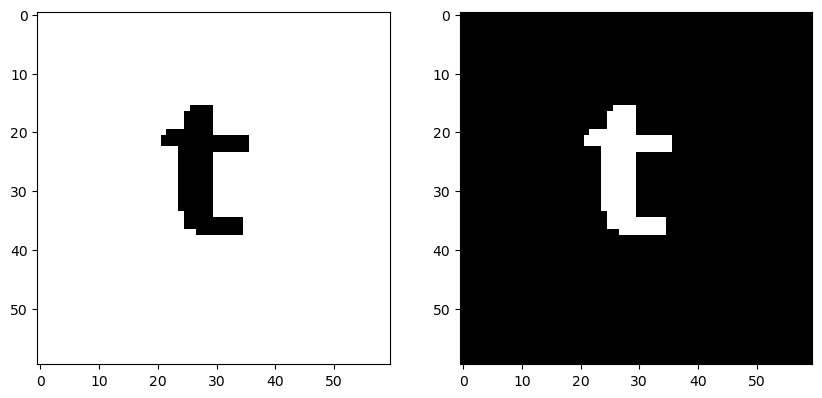

In [8]:
# Muestra de datos
print("Número de datos de entrenamiento:", len(datos))

img, label = datos[100000]
binaria = preprocesado(img)[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # imagen original en color
axs[1].imshow(binaria, cmap='gray')  # imagen binarizada
plt.show()


In [37]:
modelo = entrenar_ocr_cv2(datos)

Accuracy: 0.9690785956157547
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       383
           1       0.95      0.99      0.97       369
           2       1.00      0.99      0.99       353
           3       1.00      0.98      0.99       368
           4       0.98      0.98      0.98       381
           5       0.99      0.96      0.98       356
           6       0.98      0.99      0.98       365
           7       0.98      0.98      0.98       368
           8       1.00      1.00      1.00       354
           9       0.99      0.98      0.98       354
           A       0.98      0.96      0.97       373
           B       0.98      0.98      0.98       364
           C       0.96      0.99      0.97       342
           D       0.99      1.00      0.99       355
           E       0.99      0.97      0.98       365
           F       0.95      0.98      0.97       367
           G       1.00      0.98      0.99       36

0


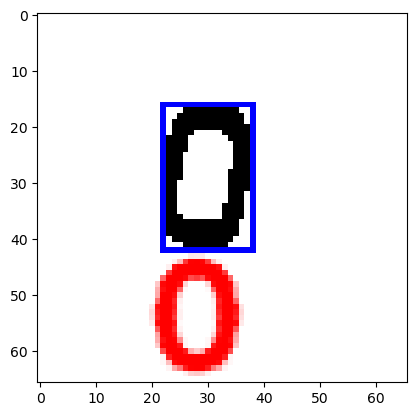

In [43]:
img = cv2.imread("E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_char/0/0004.png", cv2.IMREAD_COLOR)

print(predecir_palabra(img, modelo, show_results=True))
plt.imshow(img)

Sitios


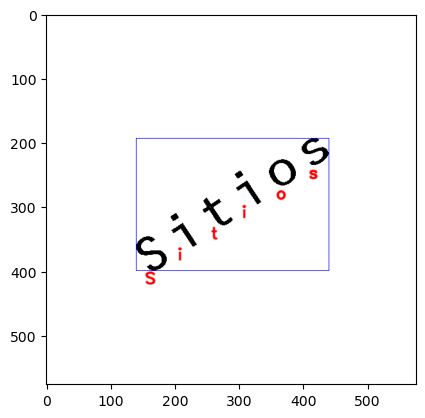

In [44]:
img = cv2.imread("E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_words_plain/0449.png", cv2.IMREAD_COLOR)

print(predecir_palabra(img, modelo, show_results=True))
plt.imshow(img)

In [28]:
# Probar el modelo
comparar_con_verdad_terreno("E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_words_plain", modelo, False, False)

❌ 0000.png → Predicho: 'CampamentO' | Esperado: 'Campamento'
✅ 0001.png → Predicho: 'ROBERT' | Esperado: 'ROBERT'
✅ 0002.png → Predicho: 'ROBERT' | Esperado: 'ROBERT'
✅ 0003.png → Predicho: 'sitios' | Esperado: 'sitios'
✅ 0004.png → Predicho: 'Pedir' | Esperado: 'Pedir'
✅ 0005.png → Predicho: 'lejos' | Esperado: 'lejos'
❌ 0006.png → Predicho: 'asesinOS' | Esperado: 'asesinos'
✅ 0007.png → Predicho: 'Grial' | Esperado: 'Grial'
❌ 0008.png → Predicho: 'retirO' | Esperado: 'retiro'
✅ 0009.png → Predicho: 'practicar' | Esperado: 'practicar'
✅ 0010.png → Predicho: 'Clima' | Esperado: 'Clima'
✅ 0011.png → Predicho: 'mulder' | Esperado: 'mulder'
✅ 0012.png → Predicho: 'INCLUYENDO' | Esperado: 'INCLUYENDO'
✅ 0013.png → Predicho: 'marca' | Esperado: 'marca'
❌ 0014.png → Predicho: 'POcOs' | Esperado: 'Pocos'
✅ 0015.png → Predicho: 'BATALLA' | Esperado: 'BATALLA'
✅ 0016.png → Predicho: 'Robert' | Esperado: 'Robert'
✅ 0017.png → Predicho: 'JAKE' | Esperado: 'JAKE'
❌ 0018.png → Predicho: 'IncluyendO

---

In [42]:
def predecir_palabra(imagen_cv2, modelo, size=(32, 32), show_results=False):
    """
    Dada una imagen de una palabra, predice cada letra utilizando el modelo entrenado.
    Filtra puntos/tildes y dibuja un rectángulo envolvente de la palabra + texto bajo cada letra.
    """
    binaria, contornos = preprocesado(imagen_cv2)

    # Paso 1: obtener todas las alturas para calcular umbral
    medidas = []
    for contorno in contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        if w > 5 and h > 5:
            medidas.append(h)

    if not medidas:
        return ""

    altura_media = sum(medidas) / len(medidas)
    umbral_altura = altura_media * 0.5  # contornos más bajos que esto se consideran puntos o tildes

    # Paso 2: filtrar y procesar contornos válidos
    letras = []
    posiciones = []

    for contorno in contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        if w > 5 and h > 5 and h >= umbral_altura:
            vector = recortar_y_redimensionar_letra(binaria, contorno, size)
            letras.append((x, vector))
            posiciones.append((x, y, w, h))

    # Ordenar izquierda a derecha
    letras.sort(key=lambda tup: tup[0])
    posiciones.sort(key=lambda tup: tup[0])
    vectores = [v for _, v in letras]

    if show_results and posiciones:
        # Rectángulo envolvente
        xs = [x for x, _, w, _ in posiciones]
        ys = [y for _, y, _, _ in posiciones]
        xws = [x + w for x, _, w, _ in posiciones]
        yhs = [y + h for _, y, _, h in posiciones]
        x_min, y_min = min(xs), min(ys)
        x_max, y_max = max(xws), max(yhs)

        cv2.rectangle(imagen_cv2, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

        cv2.imshow("Reconocimiento OCR", imagen_cv2)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # return palabra

In [29]:
def predecir_palabra(imagen_cv2, modelo, size=(32, 32), show_results=True):
    """
    Dada una imagen de una palabra, predice cada letra utilizando el modelo entrenado.
    Filtra puntos/tildes y dibuja un rectángulo envolvente de la palabra + texto bajo cada letra.
    """
    binaria, contornos = preprocesado(imagen_cv2)

    # Paso 1: calcular altura media de los contornos válidos
    medidas = []
    for contorno in contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        if w > 5 and h > 5:
            medidas.append(h)

    if not medidas:
        return ""

    altura_media = sum(medidas) / len(medidas)
    umbral_altura = altura_media * 0.5  # filtrar tildes/puntos

    letras = []
    posiciones = []

    for contorno in contornos:
        if len(contorno) == 0:
            continue

        x, y, w, h = cv2.boundingRect(contorno)

        if w <= 5 or h <= 5 or h < umbral_altura:
            continue

        # Guardar tamaño original
        original_size = max(w, h)
        if original_size < 10:
            continue

        # Ampliar rectángulo
        p = 0.1
        x_exp = max(int(round(x - w * p)), 0)
        y_exp = max(int(round(y - h * p)), 0)
        w_exp = int(round(w * (1. + 2.0 * p)))
        h_exp = int(round(h * (1. + 2.0 * p)))
        new_size = max(w_exp, h_exp)

        # Verificar límites
        if (x_exp + w_exp >= binaria.shape[1]) or (y_exp + h_exp >= binaria.shape[0]):
            continue

        # Extraer región de la letra
        letra_region = binaria[y_exp:y_exp + h_exp, x_exp:x_exp + w_exp]

        # Crear imagen cuadrada centrada
        new_size = max(letra_region.shape[:2])
        Icrop = np.zeros((new_size, new_size), dtype=np.uint8)

        y_offset = (new_size - letra_region.shape[0]) // 2
        x_offset = (new_size - letra_region.shape[1]) // 2

        Icrop[y_offset:y_offset + letra_region.shape[0], x_offset:x_offset + letra_region.shape[1]] = letra_region


        # Redimensionar
        Iresize = cv2.resize(Icrop, size, interpolation=cv2.INTER_NEAREST)

        letras.append((x, Iresize))
        posiciones.append((x, y_exp, w_exp, h_exp))

    # Ordenar de izquierda a derecha
    letras.sort(key=lambda tup: tup[0])
    posiciones.sort(key=lambda tup: tup[0])

    # Mostrar resultados
    if show_results and posiciones:
        xs = [x for x, _, w, _ in posiciones]
        ys = [y for _, y, _, _ in posiciones]
        xws = [x + w for x, _, w, _ in posiciones]
        yhs = [y + h for _, y, _, h in posiciones]
        x_min, y_min = min(xs), min(ys)
        x_max, y_max = max(xws), max(yhs)

        cv2.rectangle(imagen_cv2, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
        cv2.imshow("Reconocimiento OCR", imagen_cv2)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # return palabra


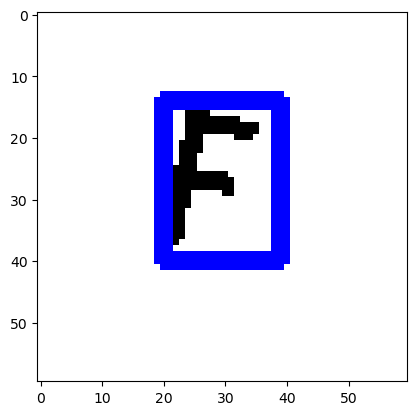

In [30]:
img = cv2.imread("E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_char/0/0004.png", cv2.IMREAD_COLOR)
img = cv2.imread("E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_char/F/0000.png", cv2.IMREAD_COLOR)

predecir_palabra(img, modelo, show_results=True)
plt.imshow(img)

---

# Prueba 4

El modelo entrenado detecta caracteres con una precisión del 87%

Tiene:
- Detector de bordes robusto

Falla:
- No detecta corréctamente las imágenes

In [45]:
# Librerías
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score


In [46]:
# Funciones

class OCRTrainingDataLoader:
    """
    Clase para leer imágenes recortadas de los datos de entrenamiento OCR generados en carpetas (una para cada carácter). 
    """

    def __init__(self, char_size=(30,30)):
        self.name = 'URJC-OCR-TRAIN'
        self.char_size = char_size  

    def load(self, data_path):
        """
        Dado un directorio donde se encuentra el conjunto de datos, lee todas las imágenes de cada carpeta (= char).

        :devuelve imágenes, donde imágenes es un diccionario de listas de imágenes cuya clave es la clase (= char).
        """
        images = dict()

        for root, _, name_files in os.walk(data_path):
            tag = os.path.basename(root)
            print("====> Loading ", tag, " images.")
            images[tag] = self.__load_images(root, name_files, self.char_size, show_results=False)

        return images
    
    def __load_images_v1(self, data_path, name_files, chars_size, show_results=False, extensiones_validas={".jpg", ".jpeg", ".png"}):
        """
        Dado un directorio donde se procesan los datos de una sola clase de caracteres, recorta las imágenes.

        :return images es una lista de imágenes
        """
        images = []

        for name in name_files:
            extension = os.path.splitext(name)[1].lower()
            if not extension in extensiones_validas:
                print("*** ERROR: Invalid extension " + name)
                continue

            I = cv2.imread(os.path.join(data_path, name), 0)    # cargamos la imagen en escala de grises.
            if not type(I) is np.ndarray:   # no es una imagen.
                print("*** ERROR: Couldn't read image " + name)
                continue

            bin_img, contours = preprocesado(I, chars_size)
            
            for contour in contours:
                if len(contour) == 0:   # descarta contornos vacíos
                    continue
                
                r = cv2.boundingRect(contour)
                x, y, w, h = r
                original_size = max(w, h)

                # Expande el rectángulo el porcentaje p
                p = 0.1
                x = max(int(round(r[0] - r[2] * p)), 0)
                y = max(int(round(r[1] - r[3] * p)), 0)
                w = int(round(r[2] * (1. + 2.0 * p)))
                h = int(round(r[3] * (1. + 2.0 * p)))
                r = (x, y, w, h)
                new_size = max(w, h)

                if max(w, h) < 10 or (w * h < 100) or (w/h > 5) or (h/w > 5):
                    continue

                if (x < 0) or (y < 0) or (x + w >= bin_img.shape[1]) or (y + h >= bin_img.shape[0]):    # verifica que el rectángulo esté dentro de los límites de la imagen
                    continue
                
                Icrop = np.zeros((new_size, new_size), dtype=np.uint8)
                x_0 = int((new_size - w) / 2)
                y_0 = int((new_size - h) / 2)

                Icrop[y_0:y_0 + h, x_0:x_0 + w] = I[y:y + h, x:x + w]
                Iresize = cv2.resize(Icrop, chars_size, interpolation=cv2.INTER_NEAREST)
                images.append(Iresize)

                # Plot results
                if show_results and (name=='0001'):
                    I2 = cv2.cvtColor(I, cv2.COLOR_GRAY2BGR)
                    x, y, w, h = r
                    cv2.rectangle(I2, (x, y), (x + w - 1, y + h - 1), (0, 255, 0), 1)
                    cv2.imshow('Letters', I2)
                    cv2.imshow('crop', cv2.resize(Icrop, None, fx=4.0, fy=4.0))
                    cv2.imshow('resize', cv2.resize(Iresize, None, fx=4.0, fy=4.0))
                    cv2.waitKey(500)

            return images

    def __load_images_v2(self, data_path, name_files, chars_size, show_results=False, extensiones_validas={".jpg", ".jpeg", ".png"}):
        """
        Dado un directorio donde se procesan los datos de una sola clase de caracteres, recorta las imágenes.

        :return images es una lista de imágenes
        """
        images = []

        for name in name_files:
            extension = os.path.splitext(name)[1].lower()
            if not extension in extensiones_validas:
                print("*** ERROR: Invalid extension " + name)
                continue

            I = cv2.imread(os.path.join(data_path, name), 0)    # cargamos la imagen en escala de grises.
            if not type(I) is np.ndarray:   # no es una imagen.
                print("*** ERROR: Couldn't read image " + name)
                continue

            bin_img, contours = preprocesado(I, chars_size)

            # Paso 1: calcular altura media de los contornos válidos
            medidas = []
            for contorno in contours:
                x, y, w, h = cv2.boundingRect(contorno)
                if w > 5 and h > 5:
                    medidas.append(h)

            if not medidas:
                return ""

            altura_media = sum(medidas) / len(medidas)
            umbral_altura = altura_media * 0.5  # filtrar tildes/puntos

            letras = []
            posiciones = []

            for contorno in contours:
                if len(contorno) == 0:
                    continue

                x, y, w, h = cv2.boundingRect(contorno)

                if w <= 5 or h <= 5 or h < umbral_altura:
                    continue

                # Guardar tamaño original
                original_size = max(w, h)
                if original_size < 10:
                    continue

                # Ampliar rectángulo
                p = 0
                x_exp = max(int(round(x - w * p)), 0)
                y_exp = max(int(round(y - h * p)), 0)
                w_exp = int(round(w * (1. + 2.0 * p)))
                h_exp = int(round(h * (1. + 2.0 * p)))
                new_size = max(w_exp, h_exp)

                # Verificar límites
                if (x_exp + w_exp >= bin_img.shape[1]) or (y_exp + h_exp >= bin_img.shape[0]):
                    continue

                # Extraer región de la letra
                letra_region = bin_img[y_exp:y_exp + h_exp, x_exp:x_exp + w_exp]

                # Crear imagen cuadrada centrada
                new_size = max(letra_region.shape[:2])
                Icrop = np.zeros((new_size, new_size), dtype=np.uint8)

                y_offset = (new_size - letra_region.shape[0]) // 2
                x_offset = (new_size - letra_region.shape[1]) // 2

                Icrop[y_offset:y_offset + letra_region.shape[0], x_offset:x_offset + letra_region.shape[1]] = letra_region

                # Redimensionar
                Iresize = cv2.resize(Icrop, chars_size, interpolation=cv2.INTER_NEAREST)
                letras.append((x, Iresize))
                posiciones.append((x, y_exp, w_exp, h_exp))
                images.append(Iresize)

            # Ordenar de izquierda a derecha
            letras.sort(key=lambda tup: tup[0])
            posiciones.sort(key=lambda tup: tup[0])

            # Mostrar resultados
            if show_results and name == '0001.png':
                xs = [x for x, _, w, _ in posiciones]
                ys = [y for _, y, _, _ in posiciones]
                xws = [x + w for x, _, w, _ in posiciones]
                yhs = [y + h for _, y, _, h in posiciones]
                x_min, y_min = min(xs), min(ys)
                x_max, y_max = max(xws), max(yhs)

                cv2.rectangle(I, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1)


                # cv2.imshow("Reconocimiento OCR", I)
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()

                plt.imshow(I)

        return images

    def __load_images(self, data_path, name_files, chars_size, show_results=False, extensiones_validas={".jpg", ".jpeg", ".png"}):
        """
        Dado un directorio donde se procesan los datos de una sola clase de caracteres, recorta las imágenes.

        :return images es una lista de imágenes
        """
        images = []

        for name in name_files:
            extension = os.path.splitext(name)[1].lower()
            if not extension in extensiones_validas:
                print("*** ERROR: Invalid extension " + name)
                continue

            I = cv2.imread(os.path.join(data_path, name), 0)    # cargamos la imagen en escala de grises.
            if not type(I) is np.ndarray:   # no es una imagen.
                print("*** ERROR: Couldn't read image " + name)
                continue

            bin_img, contours = preprocesado(I, chars_size, show_results)
            vectores = ajustar(bin_img, contours, chars_size, show_results)
            show_results = False

            images.extend(vectores)

        return images

    def load_train_data(self, data):
        """
        Carga los datos en X e y
        `data` debe ser un diccionario: {etiqueta: [imagen_cv2, ...]}
        """
        X, y = [], []

        for value, img_list in data.items():
            if img_list:
                for img in img_list:
                    X.append(img.flatten())
                    y.append(value)
            
        
        
        if not X:
                raise ValueError("No se encontraron letras válidas para entrenar el modelo.")

        return np.array(X), np.array(y)


def preprocesado(I, size=(30,30), show_results=False):
    # 1. Aplicar filtro para reducir ruido
    I = cv2.medianBlur(I, 3)

    # 2. Umbralizar la imagen
    bin_img = cv2.adaptiveThreshold(I, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # 3. Encontrar los bordes
    contours, _ = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    # cv2.RETR_EXTERNAL, cv2.RETR_LIST, cv2.RETR_CCOMP, cv2.RETR_TREE

    if show_results:
        # Dibujar los contornos en una copia de la imagen original
        imagen_contornos = cv2.cvtColor(I, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(imagen_contornos, contours, -1, (0, 255, 0), 2)

    # Mostrar resultados (cv2)
        # cv2.imshow('Imagen Original', I)
        # cv2.imshow('Imagen Binaria', bin_img)
        # cv2.imshow('Contornos', imagen_contornos)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

    # Mostrar resultados (plt)
        _, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(I, cmap='gray')
        axs[0].set_title('Imagen Original')
        axs[0].axis('off')

        axs[1].imshow(bin_img, cmap='gray')
        axs[1].set_title('Imagen Binaria')
        axs[1].axis('off')

        axs[2].imshow(imagen_contornos)
        axs[2].set_title('Contornos Detectados')
        axs[2].axis('off')

        plt.show()

    return bin_img, contours

def ajustar(bin_img, contours, size=(30,30), show_results=False):
    # Paso 1: obtener todas las alturas para calcular umbral
    medidas = []
    for contorno in contours:
        x, y, w, h = cv2.boundingRect(contorno)
        if w > 5 and h > 5:
            medidas.append(h)

    if not medidas:
        return ""

    altura_media = sum(medidas) / len(medidas)
    umbral_altura = altura_media * 0.5  # contornos más bajos que esto se consideran puntos o tildes

    # Paso 2: filtrar y procesar contornos válidos
    letras = []
    posiciones = []

    for contorno in contours:
        x, y, w, h = cv2.boundingRect(contorno)
        if w > 5 and h > 5 and h >= umbral_altura:
            recorte = bin_img[y:y+h, x:x+w]
            vector = cv2.resize(recorte, size)
            letras.append((x, vector))
            posiciones.append((x, y, w, h))

    # Ordenar izquierda a derecha
    letras.sort(key=lambda tup: tup[0])
    posiciones.sort(key=lambda tup: tup[0])
    vectores = [v for _, v in letras]

    if show_results:
        # Rectángulo envolvente
        xs = [x for x, _, w, _ in posiciones]
        ys = [y for _, y, _, _ in posiciones]
        xws = [x + w for x, _, w, _ in posiciones]
        yhs = [y + h for _, y, _, h in posiciones]
        x_min, y_min = min(xs), min(ys)
        x_max, y_max = max(xws), max(yhs)

        cv2.rectangle(bin_img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1)
        cv2.imshow("Reconocimiento OCR", bin_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        # plt.imshow(cv2.cvtColor(bin_img, cv2.COLOR_GRAY2RGB))

    return vectores


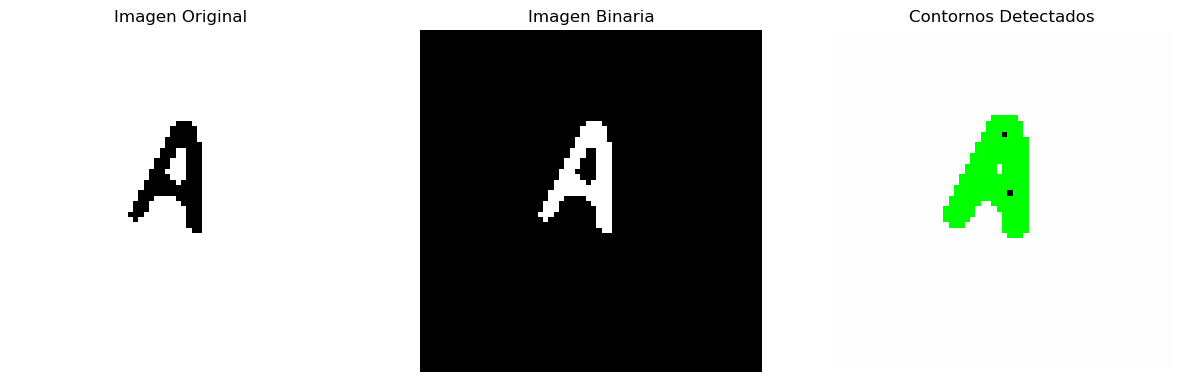

In [47]:
# Prueba preprocesado imagen
data_path = "E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_char/A"

for _, _, name_files in os.walk(data_path):
    for cont, name in enumerate(name_files):
        preprocesado(cv2.imread(os.path.join(data_path, name), 0), show_results=True)
        if cont >= 0: break               


In [48]:
# Descargar los datos y entrenar el modelo
data_ocr = OCRTrainingDataLoader()
data = data_ocr.load('E:/Practica_2_CV/Practica_2/Materiales_Practica2/train_ocr')
X, y = data_ocr.load_train_data(data)

model = RandomForestClassifier()
model.fit(X, y)

====> Loading  train_ocr  images.
====> Loading  0  images.
====> Loading  1  images.
====> Loading  2  images.
====> Loading  3  images.
====> Loading  4  images.
====> Loading  5  images.
====> Loading  6  images.
====> Loading  7  images.
====> Loading  8  images.
====> Loading  9  images.
====> Loading  may  images.
====> Loading  A  images.
====> Loading  B  images.
====> Loading  C  images.
====> Loading  D  images.
====> Loading  E  images.
====> Loading  F  images.
====> Loading  G  images.
====> Loading  H  images.
====> Loading  I  images.
====> Loading  J  images.
====> Loading  K  images.
====> Loading  L  images.
====> Loading  M  images.
====> Loading  N  images.
====> Loading  O  images.
====> Loading  P  images.
====> Loading  Q  images.
====> Loading  R  images.
====> Loading  S  images.
====> Loading  T  images.
====> Loading  U  images.
====> Loading  V  images.
====> Loading  W  images.
====> Loading  X  images.
====> Loading  Y  images.
====> Loading  Z  images.
==

RandomForestClassifier()

In [5]:
# Probar el clasificador con CHAR
data = data_ocr.load('E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_char')
X_test, y_test = data_ocr.load_train_data(data)

y_pred = model.predict(X_test)
print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred))


# Probar el clasificador con WORDS
# data = data_ocr.load('E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_words_plain')
# X_test, _ = data_ocr.load_train_data(data)

# y_pred = model.predict(X_test)
# print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 2))
# print(classification_report(y_test, y_pred))

====> Loading  test_ocr_char  images.
====> Loading  0  images.
====> Loading  1  images.
====> Loading  2  images.
====> Loading  3  images.
====> Loading  4  images.
====> Loading  5  images.
====> Loading  6  images.
====> Loading  7  images.
====> Loading  8  images.
====> Loading  9  images.
====> Loading  A  images.
====> Loading  B  images.
====> Loading  C  images.
====> Loading  D  images.
====> Loading  E  images.
====> Loading  F  images.
====> Loading  G  images.
====> Loading  H  images.
====> Loading  I  images.
====> Loading  J  images.
====> Loading  K  images.
====> Loading  L  images.
====> Loading  M  images.
====> Loading  N  images.
====> Loading  O  images.
====> Loading  P  images.
====> Loading  Q  images.
====> Loading  R  images.
====> Loading  S  images.
====> Loading  T  images.
====> Loading  U  images.
====> Loading  V  images.
====> Loading  W  images.
====> Loading  X  images.
====> Loading  Y  images.
====> Loading  Z  images.

Accuracy: 0.87


c:\Users\Diego\anaconda3\envs\ML2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1879
           1       0.95      0.95      0.95      1048
           2       0.97      0.88      0.92      1245
           3       0.91      0.92      0.91      1289
           4       0.96      0.94      0.95      1281
           5       0.94      0.92      0.93      1076
           6       0.74      0.72      0.73      2160
           7       0.98      0.98      0.98      1161
           8       0.71      0.73      0.72      2575
           9       0.76      0.78      0.77      2145
           A       0.94      0.94      0.94      1376
           B       0.83      0.69      0.75      2738
           C       0.90      0.89      0.89      1019
           D       0.95      0.95      0.95      2147
           E       0.93      0.87      0.90      1062
           F       0.94      0.90      0.92      1015
           G       0.92      0.86      0.89      1212
           H       0.95    

c:\Users\Diego\anaconda3\envs\ML2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diego\anaconda3\envs\ML2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
def cargar_gt(gt_path):
    """
    Carga el archivo gt.txt en un diccionario.
    """
    gt_dict = {}
    with open(gt_path, 'r', encoding='utf-8') as f:
        for line in f:
            partes = line.strip().split(';')
            if len(partes) == 6:
                nombre_imagen, _, _, _, _, etiqueta = partes
                gt_dict[nombre_imagen] = etiqueta
    return gt_dict

def procesar_imagen_en_letras(image_path, chars_size=(30, 30)):
    I = cv2.imread(image_path, 0)
    if I is None:
        return []

    bin_img, contours = preprocesado(I, chars_size)

    # Calcular altura media
    medidas = [cv2.boundingRect(c)[3] for c in contours if cv2.boundingRect(c)[2] > 5 and cv2.boundingRect(c)[3] > 5]
    if not medidas:
        return []

    altura_media = sum(medidas) / len(medidas)
    umbral_altura = altura_media * 0.5

    letras = []
    for contorno in contours:
        x, y, w, h = cv2.boundingRect(contorno)

        if w <= 5 or h <= 5 or h < umbral_altura:
            continue

        p = 0.1
        x_exp = max(int(round(x - w * p)), 0)
        y_exp = max(int(round(y - h * p)), 0)
        w_exp = int(round(w * (1. + 2.0 * p)))
        h_exp = int(round(h * (1. + 2.0 * p)))

        if (x_exp + w_exp >= bin_img.shape[1]) or (y_exp + h_exp >= bin_img.shape[0]):
            continue

        letra_region = bin_img[y_exp:y_exp + h_exp, x_exp:x_exp + w_exp]
        new_size = max(letra_region.shape[:2])
        Icrop = np.zeros((new_size, new_size), dtype=np.uint8)
        y_offset = (new_size - letra_region.shape[0]) // 2
        x_offset = (new_size - letra_region.shape[1]) // 2
        Icrop[y_offset:y_offset + letra_region.shape[0], x_offset:x_offset + letra_region.shape[1]] = letra_region

        Iresize = cv2.resize(Icrop, chars_size, interpolation=cv2.INTER_NEAREST)
        letras.append((x, Iresize))

    # Ordenar de izquierda a derecha
    letras.sort(key=lambda tup: tup[0])
    letras_solo = [img for _, img in letras]

    return letras_solo


def evaluar_modelo_en_dataset(modelo, images_path, gt_path):
    gt = cargar_gt(gt_path)
    total = 0
    aciertos = 0

    for nombre_img, etiqueta_esperada in gt.items():
        ruta_img = os.path.join(images_path, nombre_img)
        letras = procesar_imagen_en_letras(ruta_img)

        if not letras:
            print(f"⚠️ No se encontraron letras en {nombre_img}")
            continue

        predicciones = []
        for letra_img in letras:
            x = letra_img.flatten().reshape(1, -1)
            pred = modelo.predict(x)[0]
            predicciones.append(pred)

        palabra_predicha = ''.join(predicciones)
        if palabra_predicha == etiqueta_esperada:
            aciertos += 1
        else:
            print(f"❌ Imagen: {nombre_img} | Esperado: '{etiqueta_esperada}' | Predicho: '{palabra_predicha}'")

        total += 1

    print(f"\n✅ Precisión: {aciertos}/{total} = {aciertos/total:.2%}")



In [8]:
evaluar_modelo_en_dataset(model, "E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_words_plain", "E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_words_plain/gt.txt")


❌ Imagen: 0000.png | Esperado: 'Campamento' | Predicho: 'LX40KAhqC4CKHKmghiKAuI0I'
❌ Imagen: 0001.png | Esperado: 'ROBERT' | Predicho: 'k0u0H00AA0T'
❌ Imagen: 0002.png | Esperado: 'ROBERT' | Predicho: 'k0U0H00Ek0H'
❌ Imagen: 0003.png | Esperado: 'sitios' | Predicho: 'HNKHuOH'
❌ Imagen: 0004.png | Esperado: 'Pedir' | Predicho: 'KCNK0tK7mLI'
❌ Imagen: 0005.png | Esperado: 'lejos' | Predicho: 'HNju0H'
❌ Imagen: 0006.png | Esperado: 'asesinos' | Predicho: 'NNNHX4uCN'
❌ Imagen: 0007.png | Esperado: 'Grial' | Predicho: 'HhdN0H'
❌ Imagen: 0008.png | Esperado: 'retiro' | Predicho: 'kM0K4jKuB'
❌ Imagen: 0009.png | Esperado: 'practicar' | Predicho: 'V0hHEKXEHh'
❌ Imagen: 0010.png | Esperado: 'Clima' | Predicho: 'LK7Nm'
❌ Imagen: 0011.png | Esperado: 'mulder' | Predicho: 'NVX40m4'
❌ Imagen: 0012.png | Esperado: 'INCLUYENDO' | Predicho: 'yKLHLIHKHDu0'
❌ Imagen: 0013.png | Esperado: 'marca' | Predicho: 'MN0KLN0'
❌ Imagen: 0014.png | Esperado: 'Pocos' | Predicho: '7Bu0nu0H'
❌ Imagen: 0015.png | Espe

---

# Pruebas 5

Las fucniones son más similares a las dadas de plantilla, pero no realiza corréctamente ninguna predicción, ni caracter ni palabra

In [1]:
# Librerías

import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Clases y funciones

class OCRTrainingDataLoader:
    def __init__(self, char_size=(30,30)):
        self.name = 'URJC-OCR-TRAIN'
        self.char_size = char_size

    def load(self, data_path, show_results=False):
        images = dict()
        for root, _, file_names in os.walk(data_path):
            tag = os.path.basename(root)
            print("====> Loading ", tag, " images.")
            images[tag] = self.__load_images(root, file_names, self.char_size, show_results)

        return images
    
    def __load_images(self,data_path, file_names, size, show_results, extensiones_validas={".jpg", ".jpeg", ".png"}):
        images = []

        for name in file_names:
            extension = os.path.splitext(name)[1].lower()
            if not extension in extensiones_validas:    # no tiene la extensión adecuada
                print("*** ERROR: Invalid extension " + name)
                continue

            I = cv2.imread(os.path.join(data_path, name), 0)    # cargamos la imagen en escala de grises.
            if not type(I) is np.ndarray:   # no es una imagen.
                print("*** ERROR: Couldn't read image " + name)
                continue
            
            bin_img, contours = self.preprocesado(I, name, show_results)
            # vectores = self.__ajustar_caracter(bin_img, max(contours, key=cv2.contourArea), size)
            vectores = self.separar_caracteres(bin_img, contours, size, I, name, show_results)
            images.extend(vectores)
        
        return images


    def preprocesado(self, img, name, show_results=False):
        # 1. Aplicar filtro para reducir ruido
        soft_img = cv2.medianBlur(img, 3)

        # 2. Umbralizar la imagen
        bin_img = cv2.adaptiveThreshold(soft_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 2)

        # 3. Encontrar los bordes
        contours, _ = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    # cv2.RETR_EXTERNAL, cv2.RETR_LIST, cv2.RETR_CCOMP, cv2.RETR_TREE

        if show_results and name == '0000.png':
            # Dibujar los contornos en una copia de la imagen original
            imagen_contornos = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(imagen_contornos, contours, -1, (0, 255, 0), 2)

            # Mostrar resultados (cv2)
            # cv2.imshow('Imagen Original', img)
            # cv2.imshow('Imagen Binaria', bin_img)
            # cv2.imshow('Contornos', imagen_contornos)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

            # Mostrar resultados (plt)
            _, axs = plt.subplots(1, 3, figsize=(15, 5))

            axs[0].imshow(np.rot90(img), cmap='gray')
            axs[0].set_title('Imagen Original')
            axs[0].axis('off')

            axs[1].imshow(np.rot90(bin_img), cmap='gray')
            axs[1].set_title('Imagen Binaria')
            axs[1].axis('off')

            axs[2].imshow(np.rot90(imagen_contornos))
            axs[2].set_title('Contornos Detectados')
            axs[2].axis('off')

            plt.show()

        return bin_img, contours
            
    def __ajustar_caracter(self, bin_img, contours, size):
        contour = max(contours, key=cv2.contourArea)    # usamos el contorno más grande -> un caracter por imagen

        x, y, w, h = cv2.boundingRect(contour)
        cut = bin_img[y:y+h, x:x+w]
        roi = cv2.resize(cut, size)

        return roi.flatten()

    def separar_caracteres(self, bin_img, contours, size, img, name, show_results=False):
        medidas = [cv2.boundingRect(contour)[3] for contour in contours if cv2.boundingRect(contour)[2] > 5 and cv2.boundingRect(contour)[3] > 5]
        altura_media = sum(medidas) / len(medidas) if medidas else 1#print("No hay medidas.")
        umbral_altura = altura_media * 0.5  # contornos más bajos que esto se consideran puntos o tildes

        vectores = []
        posiciones = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            if w > 5 and h > 5 and h >= umbral_altura:
                vector = self.__ajustar_caracter(bin_img, contour, size)
                vectores.append(vector)
                posiciones.append((x, y, w, h))

        if show_results and posiciones and name == '0000.png':
            xs = [x for x, _, w, _ in posiciones]
            ys = [y for _, y, _, _ in posiciones]
            xws = [x + w for x, _, w, _ in posiciones]
            yhs = [y + h for _, y, _, h in posiciones]
            x_min, y_min = min(xs), min(ys)
            x_max, y_max = max(xws), max(yhs)

            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1)
            
            plt.figure(figsize=(5,5))
            plt.imshow(np.rot90(img))

        return vectores

    def load_train_data(self, data):
        """
        Carga los datos en X e y
        `data` debe ser un diccionario: {etiqueta: [imagen_cv2, ...]}
        """
        X, y = [], []

        for value, img_list in data.items():
            if img_list:
                for img in img_list:
                    X.append(img)
                    y.append(value)
            
        
        
        if not X:
                raise ValueError("No se encontraron letras válidas para entrenar el modelo.")

        return np.array(X), np.array(y)


In [24]:
data_ocr = OCRTrainingDataLoader()
model = RandomForestClassifier(n_estimators=100, random_state=42)

train_path = "E:/Practica_2_CV/Practica_2/Materiales_Practica2/train_ocr"
char_test_path = 'E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_char'
word_test_path = 'E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_words_plain'

In [25]:
data = data_ocr.load(train_path, False)
X_train, y_train = data_ocr.load_train_data(data)

====> Loading  train_ocr  images.
====> Loading  0  images.
====> Loading  1  images.
====> Loading  2  images.
====> Loading  3  images.
====> Loading  4  images.
====> Loading  5  images.
====> Loading  6  images.
====> Loading  7  images.
====> Loading  8  images.
====> Loading  9  images.
====> Loading  may  images.
====> Loading  A  images.
====> Loading  B  images.
====> Loading  C  images.
====> Loading  D  images.
====> Loading  E  images.
====> Loading  F  images.
====> Loading  G  images.
====> Loading  H  images.
====> Loading  I  images.
====> Loading  J  images.
====> Loading  K  images.
====> Loading  L  images.
====> Loading  M  images.
====> Loading  N  images.
====> Loading  O  images.
====> Loading  P  images.
====> Loading  Q  images.
====> Loading  R  images.
====> Loading  S  images.
====> Loading  T  images.
====> Loading  U  images.
====> Loading  V  images.
====> Loading  W  images.
====> Loading  X  images.
====> Loading  Y  images.
====> Loading  Z  images.
==

In [26]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Prueba del modelo con caracteres
data = data_ocr.load(char_test_path)
X_test, y_test = data_ocr.load_train_data(data)

y_pred = model.predict(X_test)
print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 2))

====> Loading  test_ocr_char  images.
====> Loading  0  images.
====> Loading  1  images.
====> Loading  2  images.
====> Loading  3  images.
====> Loading  4  images.
====> Loading  5  images.
====> Loading  6  images.
====> Loading  7  images.
====> Loading  8  images.
====> Loading  9  images.
====> Loading  A  images.
====> Loading  B  images.
====> Loading  C  images.
====> Loading  D  images.
====> Loading  E  images.
====> Loading  F  images.
====> Loading  G  images.
====> Loading  H  images.
====> Loading  I  images.
====> Loading  J  images.
====> Loading  K  images.
====> Loading  L  images.
====> Loading  M  images.
====> Loading  N  images.
====> Loading  O  images.
====> Loading  P  images.
====> Loading  Q  images.
====> Loading  R  images.
====> Loading  S  images.
====> Loading  T  images.
====> Loading  U  images.
====> Loading  V  images.
====> Loading  W  images.
====> Loading  X  images.
====> Loading  Y  images.
====> Loading  Z  images.

Accuracy: 0.0


---

# Prueba 6

El modelo entrenado detecta caracteres con una precisión del 97% en caracteres y 73% en palabras.
El accuracy baja en las palabras porque hay ocasiones en que las letras: (c, l, o, s, v) las confunde con sus mayúsculas y hay otras ocasiones en las que confunde (N-Z) y (O-0), pero son mínimas. Si no se tuviera en cuenta los errores de clasificación de las letras en mayúscula comparando la predicción con su valor real en minúsculas el modelo tendría un accuracy de casi 100% (99,56%)

In [11]:
# Librerías
import os
import cv2
import pickle
import numpy as np
from glob import glob
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from tabulate import tabulate  # Para mostrar los resultados en tabla

In [ ]:
# Funciones y clases
class OCRTrainingDataLoader:

    def __init__(self, char_size=(30,30)):
        self.name = 'URJC-OCR-TRAIN'
        self.char_size = char_size

    def load(self, data_path, show_results=False):
        images = dict()
        for root, _, file_names in os.walk(data_path):
            tag = os.path.basename(root)
            print("====> Loading ", tag, " images.")
            images[tag] = self.__load_images(root, file_names, show_results)

        return images
    
    def __load_images(self, data_path, file_names, show_results=False, extensiones_validas={".jpg", ".jpeg", ".png"}):
        images = []
        for name in file_names:
            if not os.path.splitext(name)[1].lower() in extensiones_validas:    # no tiene la extensión adecuada
                print("*** ERROR: Invalid extension " + name)
                continue
            
            I = cv2.imread(os.path.join(data_path, name), 1)    # cargamos la imagen en escala de grises.
            if not type(I) is np.ndarray:   # no es una imagen.
                print("*** ERROR: Couldn't read image " + name)
                continue

            bin_img, contours = process_img(I, name, show_results)
            vector = cut_img(bin_img, max(contours, key=cv2.contourArea), self.char_size)
            images.append(vector)

        return images
    

def process_img(img, name=None, show_results=False):
    # 1. Cargamos la imagen en escala de grises
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Umbralizar la imagen
    bin_img = cv2.adaptiveThreshold(grey, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # 3. Encontrar los bordes
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    # cv2.RETR_EXTERNAL, cv2.RETR_LIST, cv2.RETR_CCOMP, cv2.RETR_TREE

    # Visualización
    if show_results and name == '0000.png':
        # Dibujar los contornos en una copia de la imagen original
        imagen_contornos = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(imagen_contornos, contours, -1, (0, 255, 0), 2)

        # Mostrar resultados (cv2)
        cv2.imshow('Imagen Original', img)
        cv2.imshow('Imagen Binaria', bin_img)
        cv2.imshow('Contornos', imagen_contornos)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # Mostrar resultados (plt)
        # _, axs = plt.subplots(1, 3, figsize=(15, 5))

        # axs[0].imshow(np.rot90(img), cmap='gray')
        # axs[0].set_title('Imagen Original')
        # axs[0].axis('off')

        # axs[1].imshow(np.rot90(bin_img), cmap='gray')
        # axs[1].set_title('Imagen Binaria')
        # axs[1].axis('off')

        # axs[2].imshow(np.rot90(imagen_contornos))
        # axs[2].set_title('Contornos Detectados')
        # axs[2].axis('off')

        # plt.show()

    return bin_img, contours

def cut_img(bin_img, contour, size=(30,30)):
    x, y, w, h = cv2.boundingRect(contour)
    cut = bin_img[y:y+h, x:x+w]
    roi = cv2.resize(cut, size)
    
    return roi.flatten()
          
def word_predict(img, model, show_results=False):
    bin_img, contours = process_img(img, show_results=True)

    # Paso 1: Obtener todas las alturas para calcular umbral
    medidas = [cv2.boundingRect(contour)[3] for contour in contours if cv2.boundingRect(contour)[2] > 5 and cv2.boundingRect(contour)[3] > 5]
    if not medidas:
        return "", (0, 0, img.shape[1], img.shape[0])  # Devuelve caja completa si no hay letras

    altura_media = sum(medidas) / len(medidas)
    umbral_altura = altura_media * 0.5  # Filtrar contornos demasiado pequeños

    # Paso 2: Filtrar y procesar contornos válidos
    letras = []
    posiciones = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 5 and h > 5 and h >= umbral_altura:
            vector = cut_img(bin_img, contour)
            letras.append((x, vector))
            posiciones.append((x, y, w, h))

    # Ordenar de izquierda a derecha
    letras.sort(key=lambda tup: tup[0])
    posiciones.sort(key=lambda tup: tup[0])
    vectores = [v for _, v in letras]

    palabra = "".join(model.predict(vectores)) if vectores else ""

    if posiciones:
        xs = [x for x, _, w, _ in posiciones]
        ys = [y for _, y, _, _ in posiciones]
        xws = [x + w for x, _, w, _ in posiciones]
        yhs = [y + h for _, y, _, h in posiciones]
        x_min, y_min = min(xs), min(ys)
        x_max, y_max = max(xws), max(yhs)
    else:
        x_min, y_min, x_max, y_max = 0, 0, img.shape[1], img.shape[0]  # Caja completa por defecto

    if show_results and posiciones:
        # Rectángulo rojo envolvente de la palabra
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

        # Dibujar los rectángulos amarillos en cada letra
        for x, y, w, h in posiciones:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 1)

        # Mostrar cada letra predicha directamente debajo de su respectiva letra original
        for (x, y, w, h), letra in zip(posiciones, palabra):
            baseline_y = y + h + 30 # Ajuste para colocar la letra debajo del rectángulo amarillo
            cv2.putText(img, letra, (x + w // 4, baseline_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)
            
        cv2.imshow("Reconocimiento OCR", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return palabra, (x_min, y_min, x_max, y_max)


def model_data(data):
    X, y = [], []

    for value, img_list in data.items():
        for img in img_list or []:
            X.append(img)
            y.append(value)
            
    return np.array(X), np.array(y)

def evaluate_ocr(word_test_path, gt_path, model, verbose=False, show_resluts=False):
    # Cargar las respuestas correctas desde gt.txt
    gt_dict = {}

    with open(gt_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(";")
            filename = parts[0]  # Nombre de la imagen
            ground_truth = parts[-1]  # Última columna con la respuesta correcta
            gt_dict[filename] = ground_truth

    y_pred = []
    y_true = []

    # Procesar las imágenes y comparar predicciones
    for root, _, file_names in os.walk(word_test_path):
        for name in file_names:
            if os.path.splitext(name)[1].lower() in {".jpg", ".jpeg", ".png"}:
                img_path = os.path.join(root, name)
                img = cv2.imread(img_path, 1)

                if img is None:
                    print(f"Error al cargar la imagen: {name}")
                    continue
                
                if name != '0000.png': show_resluts = False
                pred, _ = word_predict(img, model, show_resluts)
                ground_truth = gt_dict.get(name, "Desconocido")  # Obtener respuesta correcta

                y_pred.append(pred.lower())
                y_true.append(ground_truth.lower())

                if verbose:
                    print(f"Imagen: {name} | Predicción: {pred} | Ground Truth: {ground_truth}")

    # Calcular precisión
    accuracy = accuracy_score(y_true, y_pred) * 100
    return accuracy

def predecir_palabra(model, input_folder, results_file):
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path, 1)

            if img is None:
                print(f"[ERROR] No se pudo leer la imagen: {img_path}")
                continue

            texto_ocr, (x1, y1, x2, y2) = word_predict(img, model, show_results=False)
            linea_resultado = f"{filename};{x1};{y1};{x2};{y2};{texto_ocr}\n"
            results_file.write(linea_resultado)
            # print(f"[INFO] Procesado: {filename} -> {texto_ocr}")


In [ ]:
# Declaración de valores
train_path = "E:/Practica_2_CV/Practica_2/Materiales_Practica2/train_ocr"
char_test_path = "E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_char"
word_test_path = "E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_words_plain"
gt_path = "E:/Practica_2_CV/Practica_2/Materiales_Practica2/test_ocr_words_plain/gt.txt"

load_ocr = OCRTrainingDataLoader()
model_configs = [
    ("NaiveBayes", GaussianNB()),
    ("KNN", KNeighborsClassifier(n_neighbors=7)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))
]


In [4]:
# Carga de datos
train_data = load_ocr.load(train_path, False)
X_train, y_train = model_data(train_data)

char_test_data = load_ocr.load(char_test_path, False)
X_char_test, y_char_test = model_data(char_test_data)

====> Loading  train_ocr  images.
====> Loading  0  images.
====> Loading  1  images.
====> Loading  2  images.
====> Loading  3  images.
====> Loading  4  images.
====> Loading  5  images.
====> Loading  6  images.
====> Loading  7  images.
====> Loading  8  images.
====> Loading  9  images.
====> Loading  may  images.
====> Loading  A  images.
====> Loading  B  images.
====> Loading  C  images.
====> Loading  D  images.
====> Loading  E  images.
====> Loading  F  images.
====> Loading  G  images.
====> Loading  H  images.
====> Loading  I  images.
====> Loading  J  images.
====> Loading  K  images.
====> Loading  L  images.
====> Loading  M  images.
====> Loading  N  images.
====> Loading  O  images.
====> Loading  P  images.
====> Loading  Q  images.
====> Loading  R  images.
====> Loading  S  images.
====> Loading  T  images.
====> Loading  U  images.
====> Loading  V  images.
====> Loading  W  images.
====> Loading  X  images.
====> Loading  Y  images.
====> Loading  Z  images.
==

In [5]:
# Entrenar y guardar modelos
for name, model in model_configs:
    print(f"Entrenando modelo: {name}...")
    model.fit(X_train, y_train)
    
    # Guardar modelo entrenado
    with open(f"models/model_{name}.pkl", "wb") as f:
        pickle.dump(model, f)


Entrenando modelo: NaiveBayes...
Entrenando modelo: KNN...
Entrenando modelo: RandomForest...


In [6]:
# Evaluar modelos con caracteres y guardar resultados
resultados = []
for name, _ in model_configs:
    # Cargar modelo guardado
    with open(f"models/model_{name}.pkl", "rb") as f:
        model = pickle.load(f)

    # Evaluar el modelo
    y_pred = model.predict(X_char_test)
    accuracy = accuracy_score(y_char_test, y_pred) * 100
    resultados.append([name, f"{accuracy:.2f}%"])

# Mostrar resultados en tabla
print(tabulate(resultados, headers=["Modelo", "Precisión"], tablefmt="grid"))

+--------------+-------------+
| Modelo       | Precisión   |
+==============+=============+
| NaiveBayes   | 42.67%      |
+--------------+-------------+
| KNN          | 95.10%      |
+--------------+-------------+
| RandomForest | 96.56%      |
+--------------+-------------+


In [7]:
# Evaluar modelos con palabras y guardar resultados
resultados = []
for name, _ in model_configs:
    # Cargar modelo guardado
    with open(f"models/model_{name}.pkl", "rb") as f:
        model = pickle.load(f)

    # Evaluar el modelo
    accuracy = evaluate_ocr(word_test_path, gt_path, model, verbose=False, show_resluts=True)
    resultados.append([name, f"{accuracy:.2f}%"])

# Mostrar resultados en tabla
print(tabulate(resultados, headers=["Modelo", "Precisión"], tablefmt="grid"))

+--------------+-------------+
| Modelo       | Precisión   |
+==============+=============+
| NaiveBayes   | 14.67%      |
+--------------+-------------+
| KNN          | 99.78%      |
+--------------+-------------+
| RandomForest | 99.56%      |
+--------------+-------------+


In [11]:
input_folder = "test_ocr_words_plain"  # carpeta con las imágenes de prueba
results_file = open("results_ocr_words_plain/results_text_lines.txt", "w")

predecir_palabra(model, input_folder, results_file)

---

Tras realizar las distancias de Levenshtein estas son las conclusiones:

### Conclusiones

- Buen rendimiento general: \
El 66% de las imágenes fueron reconocidas perfectamente.\
Más del 85% tienen 0 o 1 errores → excelente para un sistema OCR.

- Errores están controlados: \
Solo un 13% de los casos tienen errores mayores a 1 letra. \
Los errores severos son extremadamente raros.

- Áreas de mejora: \
Revisa ejemplos con distancia 2–3 para ver si hay patrones comunes de fallo (letras confundidas, mala segmentación, etc.). \
La mejora del preprocesado de imagen o del modelo puede reducir esos errores residuales.

---

## Ejercicio 4: Unión con la práctica 1

In [75]:
class Model3D:
    def __init__( self ):
        self.vertices = None
        self.faces = None
        self.face_centroids = None
        self.color_map = None

    def load_from_obj(self, file_path):
        """
        Adapted from: https://medium.com/@harunijaz/the-code-above-is-a-python-function-that-reads-and-loads-data-from-a-obj-e6f6e5c3dfb9

        :param file_path: full path of the .obj file to load
        """
        try:
            vertices = []
            faces = []
            with open(file_path) as f:
               for line in f:
                   if line[0] == "v":
                       vertex = list(map(float, line[2:].strip().split()))
                       vertices.append(vertex)
                   elif line[0] == "f":
                       face = list(map(int, line[2:].strip().split()))
                       faces.append(face)

            self.vertices = np.array(vertices)
            self.faces = np.array(faces)

            # Compute triangle centroids (for z-buffer plot)
            self.face_centroids = []
            for i in range(self.faces.shape[0]):
                p0 = self.faces[i, 0] - 1
                p1 = self.faces[i, 1] - 1
                p2 = self.faces[i, 2] - 1
                vertices = np.vstack((self.vertices[p0, :],
                                      self.vertices[p1, :],
                                      self.vertices[p2, :]))
                self.face_centroids.append(np.mean(vertices, axis=0))
            self.face_centroids = np.array(self.face_centroids)

        except FileNotFoundError:
            print(f"{file_path} not found.")
        except:
            print("An error occurred while loading the shape.")

    def translate(self, t):
        assert t.shape == (1, 3)

        if not self.vertices is None:
            self.vertices += t
            self.face_centroids += t

    def scale(self, scale):
        assert isinstance(scale, float)

        if not self.vertices is None:
            self.vertices *= scale
            self.face_centroids *= scale
   
    def rotate(self, angle_degrees, axis="z"):
        """
        Rota el modelo 3D en torno a un eje dado ('x', 'y', 'z') en grados.

        :param angle_degrees: Ángulo de rotación en grados.
        :param axis: Eje de rotación ('x', 'y' o 'z').
        """
        angle_radians = np.radians(angle_degrees)  # Convertir grados a radianes
        cos_theta = np.cos(angle_radians)
        sin_theta = np.sin(angle_radians)

        # Definir la matriz de rotación según el eje elegido
        if axis == "x":
            R = np.array([[1, 0, 0],
                        [0, cos_theta, -sin_theta],
                        [0, sin_theta, cos_theta]])
        elif axis == "y":
            R = np.array([[cos_theta, 0, sin_theta],
                        [0, 1, 0],
                        [-sin_theta, 0, cos_theta]])
        else:  # Rotación en el eje Z (por defecto)
            R = np.array([[cos_theta, -sin_theta, 0],
                        [sin_theta, cos_theta, 0],
                        [0, 0, 1]])

        # Aplicar la rotación a los vértices y los centroides de las caras
        if self.vertices is not None:
            self.vertices = np.dot(self.vertices, R.T)
            self.face_centroids = np.dot(self.face_centroids, R.T)

    def plot_on_image(self, img, P):
        # Verificar si color_map existe y tiene el tamaño correcto
        if self.color_map is None or self.color_map.shape[0] < self.faces.shape[0]:
            self.color_map = np.int32(255 * np.random.rand(self.faces.shape[0], 3))  # Asegurar tamaño correcto

        # Transformación de vértices
        vertices3D = self.vertices.copy()
        vertices3D = np.hstack((vertices3D, np.ones((vertices3D.shape[0], 1))))
        vertices2D = P @ vertices3D.T
        vertices2D /= vertices2D[2, :]
        vertices2D = np.int32(np.round(vertices2D))

        # Calcular la distancia de cada triángulo a la cámara
        distances = []
        centroids = np.hstack((self.face_centroids, np.ones((self.face_centroids.shape[0], 1)))).T
        for i in range(self.faces.shape[0]):
            triangle_depth = P[2, :] @ centroids[:, i]
            triangle_depth /= np.linalg.norm(P[2, 0:3])
            triangle_depth *= np.sign(np.linalg.det(P[0:3, 0:3]))
            distances.append(triangle_depth)

        # Ordenar por distancia (z-buffer)
        distances = np.array(distances)
        dist_sorted_indices = distances.argsort()[::-1]

        # Dibujar cada triángulo en la imagen
        for i in dist_sorted_indices:
            # Asegurar que `i` no exceda los límites de `color_map`
            i = np.clip(i, 0, self.color_map.shape[0] - 1)

            p0 = self.faces[i, 0] - 1
            p1 = self.faces[i, 1] - 1
            p2 = self.faces[i, 2] - 1
            pt0 = vertices2D[0:2, p0]
            pt1 = vertices2D[0:2, p1]
            pt2 = vertices2D[0:2, p2]

            # Asignación segura de color
            color = (int(self.color_map[i, 0]), 
                    int(self.color_map[i, 1]), 
                    int(self.color_map[i, 2]))

            pts = np.vstack((pt0, pt1, pt2))
            cv2.fillPoly(img, [pts], color)


# Obtiene los KeyPoints de la imagen
def get_key_points(template_img, query_img, detector, matcher):
    keypoints_template, descriptors_template = detector.detectAndCompute(template_img, None)
    keypoints_scene, descriptors_scene = detector.detectAndCompute(query_img, None)
    good_matches = get_matches(descriptors_template, descriptors_scene, matcher)

    return keypoints_template, keypoints_scene, good_matches

def get_matches(descriptors_template, descriptors_scene, matcher):
    matches = matcher.knnMatch(descriptors_template, descriptors_scene, 2)
    ratio_thresh = 0.75
    good_matches = []

    for m,n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    return good_matches


# Obtener la homografía del template a la escena
def get_homography_tmpl_scene(keypoints_template, keypoints_scene, good_matches):
    template = np.empty((len(good_matches),2), dtype=np.float32)
    scene = np.empty((len(good_matches),2), dtype=np.float32)
    for i in range(len(good_matches)):
        #-- Obtener los keypoints de los matches buenos
        template[i,0] = keypoints_template[good_matches[i].queryIdx].pt[0]
        template[i,1] = keypoints_template[good_matches[i].queryIdx].pt[1]
        scene[i,0] = keypoints_scene[good_matches[i].trainIdx].pt[0]
        scene[i,1] = keypoints_scene[good_matches[i].trainIdx].pt[1]

    H_t_img, _ =  cv2.findHomography(template, scene, cv2.RANSAC)   # Homografía template-scena
    return H_t_img

# Obtener la homografía de la imagen en mm (wold) al template
def get_homography_wToTemplate(template_img):
    y_img = template_img.shape[0]-1
    x_img = template_img.shape[1]-1

    pts_mm = np.float32([[0, 0], [0, 210], [185, 210], [185, 0]])    # Cogemos las distancias estableciendo x como el alto e y como el ancho por la representación de cv2
    pts_tmpl = np.float32([[0, 0], [x_img, 0], [x_img, y_img], [0, y_img]])  # puntos de las esquinas de la imagen template

    H_w_t = cv2.getPerspectiveTransform(pts_mm, pts_tmpl)

    return H_w_t

# Calcular la matriz de proyección
def compute_projection_matrix(H, K):
    """
    Calcula la matriz de proyección P = K [R | t] (3x4)
    a partir de la homografía H (3x3) y la intrínseca K (3x3).
    """
    # 1. Inversa de K por H
    K_inv = np.linalg.inv(K)
    H_norm = K_inv @ H

    # 2. Escalado
    h1, h2, h3 = H_norm[:, 0], H_norm[:, 1], H_norm[:, 2]
    lambda_ = 1.0 / np.linalg.norm(h1)
    r1 = lambda_ * h1
    r2 = lambda_ * h2
    t  = lambda_ * h3

    # 3. Ortonormalización de R
    r3 = np.cross(r1, r2)
    R = np.column_stack((r1, r2, r3))   

    # 4. Formar P
    Rt = np.column_stack((R, t))
    P = K @ Rt

    return P

# Imagen query mostrada con las dimensiones reales
def img_to_world(query_img, H_img_w, dim=(210, 185), roi_start=210, roi_end=292):
    # Aplicar la transformación de perspectiva
    transformed_img = cv2.warpPerspective(query_img, H_img_w, dim)

    # Recortar la imagen en el rango deseado
    roi_img = transformed_img[roi_start:roi_end, :]  # Recorta filas de 220 a 290
    img = cv2.flip(roi_img, 0)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img


# Mostrar ejes origen
def view_orig(img, P, axes_len):
    # 1. Definimos los 4 puntos homogéneos (origen, X, Y, Z)
    pts_orig_hom = np.array([
        [0,          0,          0, 1],    # Origen
        [axes_len,   0,          0, 1],    # Eje X
        [0,   axes_len,          0, 1],    # Eje Y
        [0,          0,   axes_len, 1]     # Eje Z
    ])

    # 2. Proyectar a 2D con la homografía
    #    pts_proj será 3×4, cada columna [x, y, w]
    pts_proj = P @ pts_orig_hom.T
    pts_proj /= pts_proj[2, :]            # normalizamos por w

    # 3. Calculamos los vectores de cada eje en la imagen
    origin2d = pts_proj[:2, 0]            # (x,y) del origen
    vec_X    = pts_proj[:2, 1] - origin2d # dirección X
    vec_Y    = pts_proj[:2, 2] - origin2d # dirección Y
    vec_Z    = pts_proj[:2, 3] - origin2d # dirección Z

    # 5. Convertimos a tuplas de int para cv2.line
    origin_pt  = tuple(origin2d.astype(int))
    x_axis_end = tuple(pts_proj[:2, 1].astype(int))
    y_axis_end = tuple(pts_proj[:2, 2].astype(int))
    z_axis_end = tuple(pts_proj[:2, 3].astype(int))

    # 6. Dibujamos sobre la imagen
    cv2.line(img, origin_pt, x_axis_end, (0, 0, 255), 4)    # eje X en rojo (BGR)
    cv2.line(img, origin_pt, y_axis_end, (0, 255, 0), 4)    # eje Y en verde
    cv2.line(img, origin_pt, z_axis_end, (255, 0, 0), 4)    # eje Z en azul

    return img

# Mostrar bordes
def view_edge(img, H, pts_hom):
    # Proyectar puntos a 2D
    limit_pts = H @ pts_hom.T
    limit_pts /= limit_pts[2]     # Normalizar

    # Convertir los puntos a int para usarlos en cv2.line
    limit_pts = limit_pts[:2, :].T  # Ahora es (4,2): cada fila es (x,y)

    # Añadir el primer punto al final para cerrar el borde
    limit_pts = np.vstack([limit_pts, limit_pts[0]])

    # Dibujar las líneas conectando los puntos
    for i in range(len(limit_pts) - 1):
        pt1 = tuple(limit_pts[i].astype(int))
        pt2 = tuple(limit_pts[i + 1].astype(int))
        cv2.line(img, pt1, pt2, color=(255, 0, 255), thickness=4)  # Magenta en BGR

    return img

# Guardamos las imágenes
def save_result_image(image, images_path, input_filename):
    # Crear el directorio 'resultado_imgs' si no existe
    result_dir = os.path.join(images_path, "resultado_imgs")
    os.makedirs(result_dir, exist_ok=True)

    # Generar el nombre del archivo de salida
    output_filename = f"resultado_{os.path.basename(input_filename)}"
    output_path = os.path.join(result_dir, output_filename)

    # Guardar la imagen
    cv2.imwrite(output_path, image)

# Calcula las distancias de Levenshtein
def levenshtein_distance(str1, str2):
    """
    https://ast.wikipedia.org/wiki/Distancia_de_Levenshtein
    """
    d = dict()
    for i in range(len(str1) + 1):
        d[i] = dict()
        d[i][0] = i
    for i in range(len(str2) + 1):
        d[0][i] = i
    for i in range(1, len(str1) + 1):
        for j in range(1, len(str2) + 1):
            d[i][j] = min(d[i][j - 1] + 1, d[i - 1][j] + 1, d[i - 1][j - 1] + (not str1[i - 1] == str2[j - 1]))

    return d[len(str1)][len(str2)]

# Devuelve la figura con la distancia de Levenshtein más cercana
def figura_mas_cercana(palabra):
    figuras = ["cubo", "dodecaedro", "icosaedro", "octaedro", "tetraedro"]
    distancias = [(figura, levenshtein_distance(palabra.lower(), figura)) for figura in figuras]
    figura_cercana = min(distancias, key=lambda x: x[1])
    return figura_cercana[0]


def show_figure(img_path, figures_path, detector, matcher, model, limit_pts_hom, pts_mm_hom, fig_class, show_results=False):
    # Cargamos la imagen de la plantilla
    template_img_path = os.path.join(img_path, "template_cropped.png")
    template_img = cv2.imread(template_img_path)
    if template_img is None:
            print("No puedo encontrar la imagen " + template_img_path)

    # Cargamos la matriz de intrínsecos de la cámara
    K = np.loadtxt(os.path.join(img_path, "intrinsics.txt"))

    # Cargamos el directorio de las imágenes
    paths = sorted(glob(os.path.join(img_path, "*.jpg")))

    # Inicializamos el error
    error_acumulado = 0
    img_count = 0

    # Iteramos por cada imagen
    for f in paths:
        query_img_path = f
        if not os.path.isfile(query_img_path):
                continue

        query_img = cv2.imread(query_img_path)
        if query_img is None:
                print("No puedo encontrar la imagen " + query_img_path)
                continue

        # Localizar el plano en la imagen y calcular R, t -> P
        # 1. Calcular Key Points para calcular las homografías
        keypoints_template, keypoints_scene, good_matches = get_key_points(template_img, query_img, detector, matcher)

        # 2. Calcular las Homografías
        H_t_img = get_homography_tmpl_scene(keypoints_template, keypoints_scene, good_matches)
        H_w_t = get_homography_wToTemplate(template_img)
        H_w_img = H_t_img @ H_w_t

        # 3. Calcular la matriz de proyección
        P = compute_projection_matrix(H_w_img, K)

        # Mostrar la imagen con los bordes y el origen
        img = query_img.copy()
        img = view_edge(img, H_w_img, limit_pts_hom) # Muestra el borde exterior
        img = view_edge(img, H_w_img, pts_mm_hom)    # Muestra el borde donde debe ir el cubo

        # Mostrar los ejes del sistema de referencia de la plantilla sobre una copia de la imagen de entrada.
        img = view_orig(img, P, 20)

        # Obtener imagen para OCR
        H_img_w = np.linalg.inv(H_w_img)
        ocr_img = img_to_world(query_img, H_img_w, dim=(195, 290), roi_start=210, roi_end=292)

        word, _ = word_predict(ocr_img, model, False)  # La predicción no es muy buena pero vamos a intentar que se acerce seleccionando la figura más cercana por la distancia de Levenshtein
        figure = figura_mas_cercana(word)

        # Cargar el modelo 3D del cubo y colocarlo en el lugar pedido.
        model_3d_file = os.path.join(figures_path, f"{figure}.obj")
        print("Cargando el modelo 3D " + model_3d_file)

        fig_class.load_from_obj(file_path=model_3d_file)
        escala = 43.0/2.0
        traslacion = np.array([[92.5, 126.5, escala]]) # Traslación en XYZ
        if figure == "octaedro": 
            fig_class.rotate(angle_degrees=45, axis="z")
            traslacion = np.array([[92.5, 126.5, escala*2]]) # Traslación en XYZ
        # if figure == "tetraedro": fig_class.rotate(angle_degrees=, axis="y")
        fig_class.scale(scale=escala)
        fig_class.translate(t=traslacion)


        # Mostrar el modelo 3D del cubo sobre la imagen plot_img
        fig_class.plot_on_image(img=img, P=P)

        # Mostrar el resultado en pantalla.
        if show_results:
            plt.figure(figsize=(30, 15))
            plt.subplot(1, 3, 1)
            plt.imshow(query_img)
            plt.subplot(1, 3, 2)
            plt.imshow(ocr_img)
            plt.subplot(1, 3, 3)
            plt.imshow(img)
            plt.show()

            # cv2.imshow("3D info on images", cv2.resize(img, None, fx=0.3, fy=0.3))
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

        # Guardar imagenes
        save_result_image(img, img_path, f"{figure}_{os.path.basename(f)}")


In [76]:
# Cargamos las direcciones de los directorios
test_ocr_simple_path = "test_template_ocr_simple"
test_ocr_path = "test_template_ocr"
figures_path = "3d_models"
model_ocr = "models/model_RandomForest.pkl"

# Cargamos el detector y el matcher
nfeatures = 4000
detector = cv2.SIFT_create(nfeatures)
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

# Cargamos el modelo OCR
with open(model_ocr, "rb") as pickle_file:
    clf = pickle.load(pickle_file)

# Inicializamos la clase Modelo3d
m3D = Model3D()

# Inicializamos los límites
limit_pts_hom = np.float32([[0,   0,   1], 
                            [185, 0,   1], 
                            [185, 210, 1], 
                            [0,   210, 1]         
])
pts_mm_hom = np.float32([[71,  105, 1], 
                         [71,  148, 1], 
                         [114, 148, 1], 
                         [114, 105, 1]       
])

Cargando el modelo 3D 3d_models\octaedro.obj


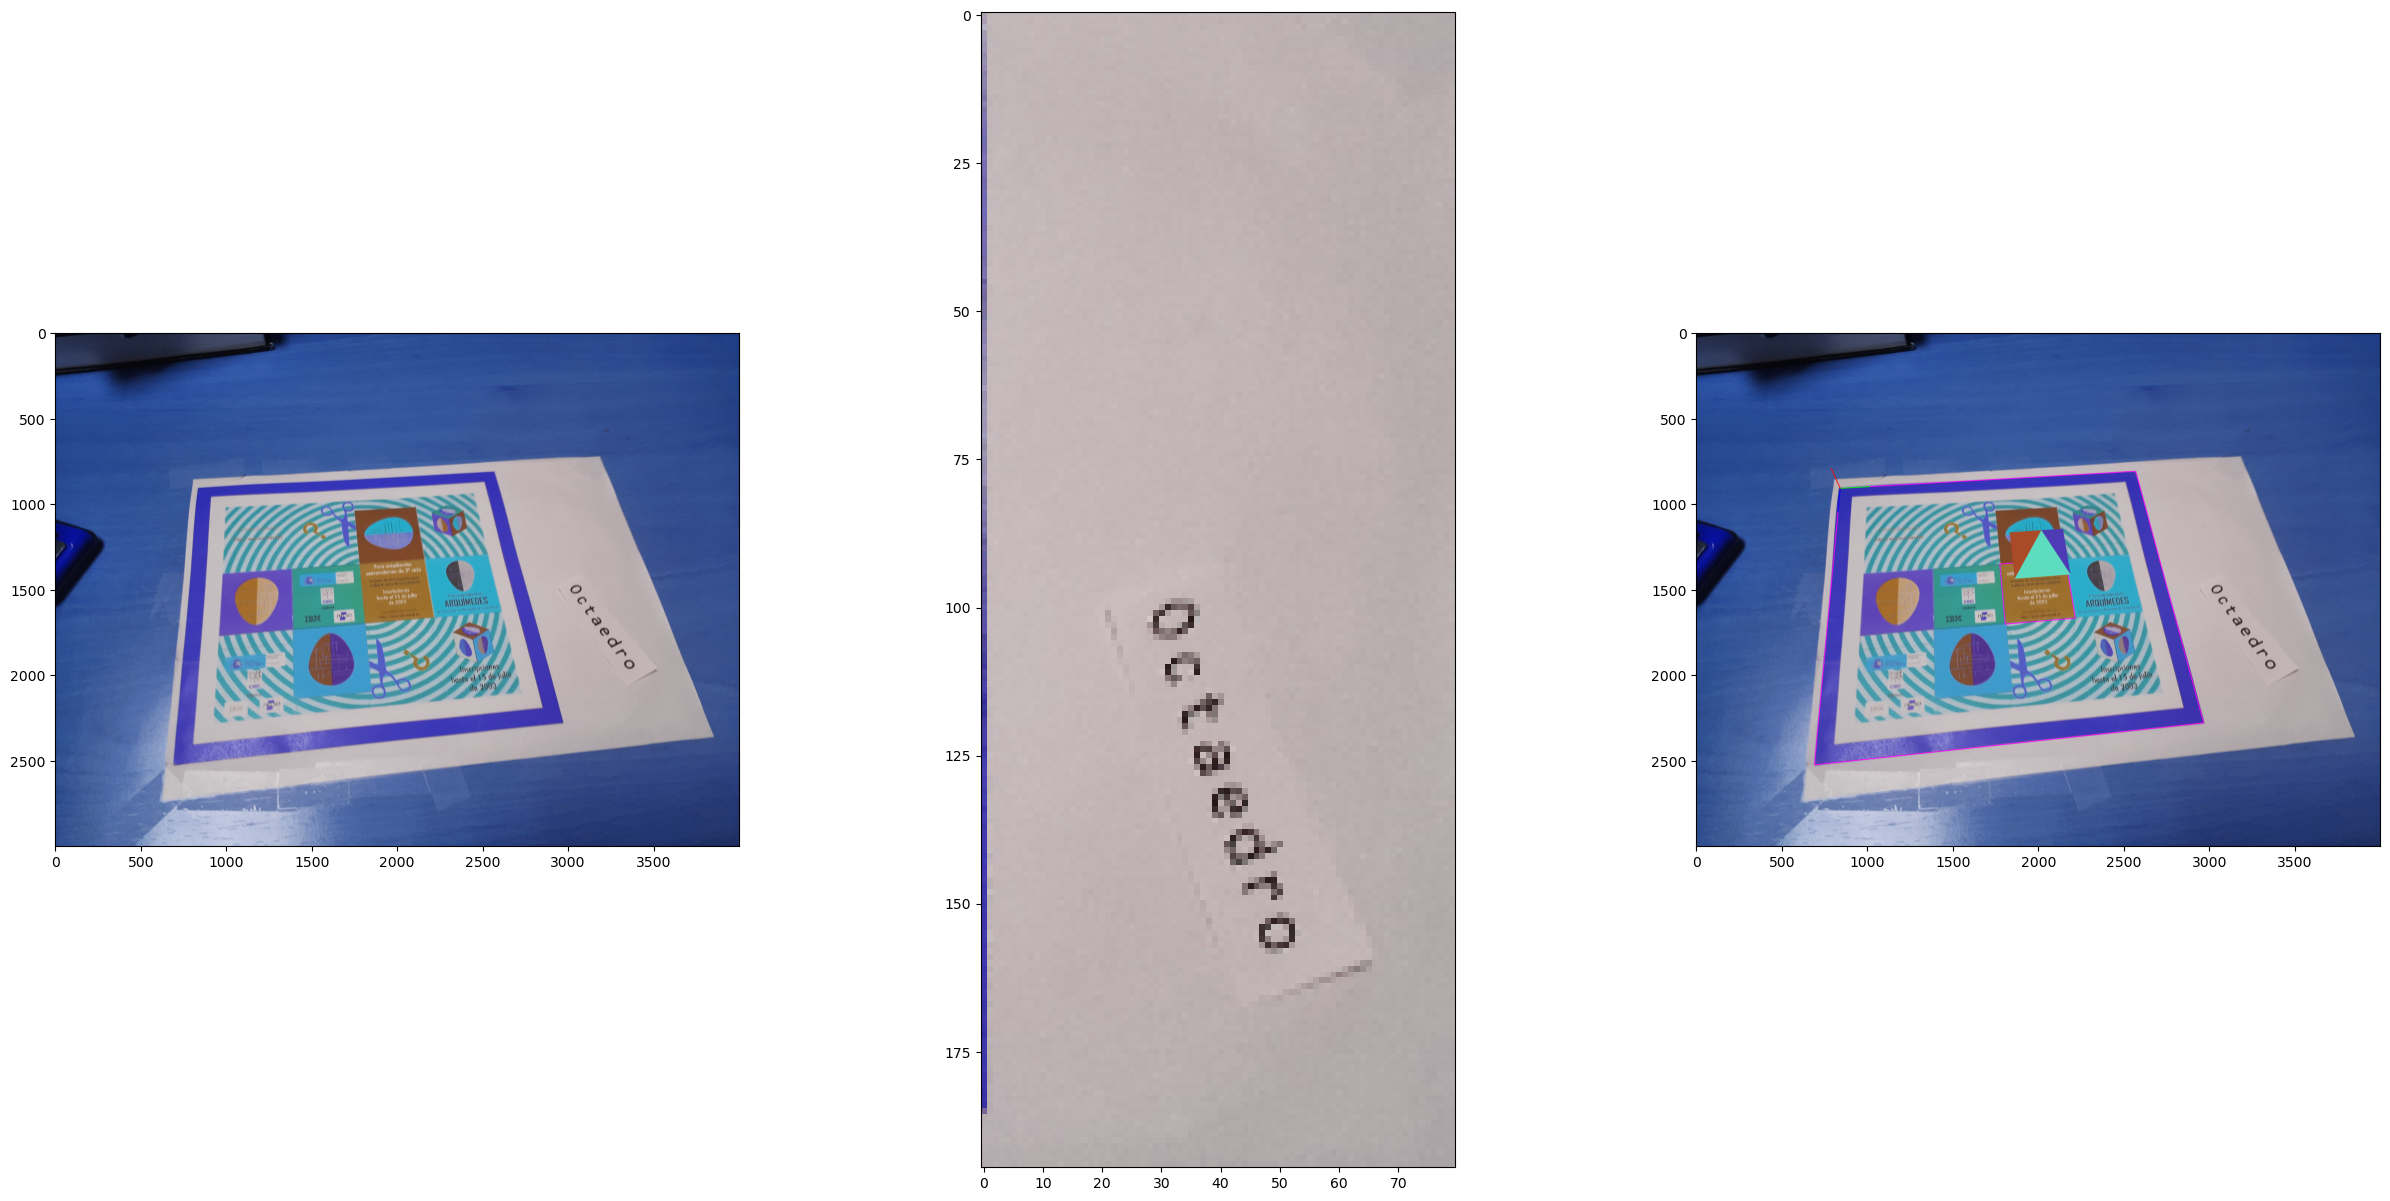

Cargando el modelo 3D 3d_models\icosaedro.obj


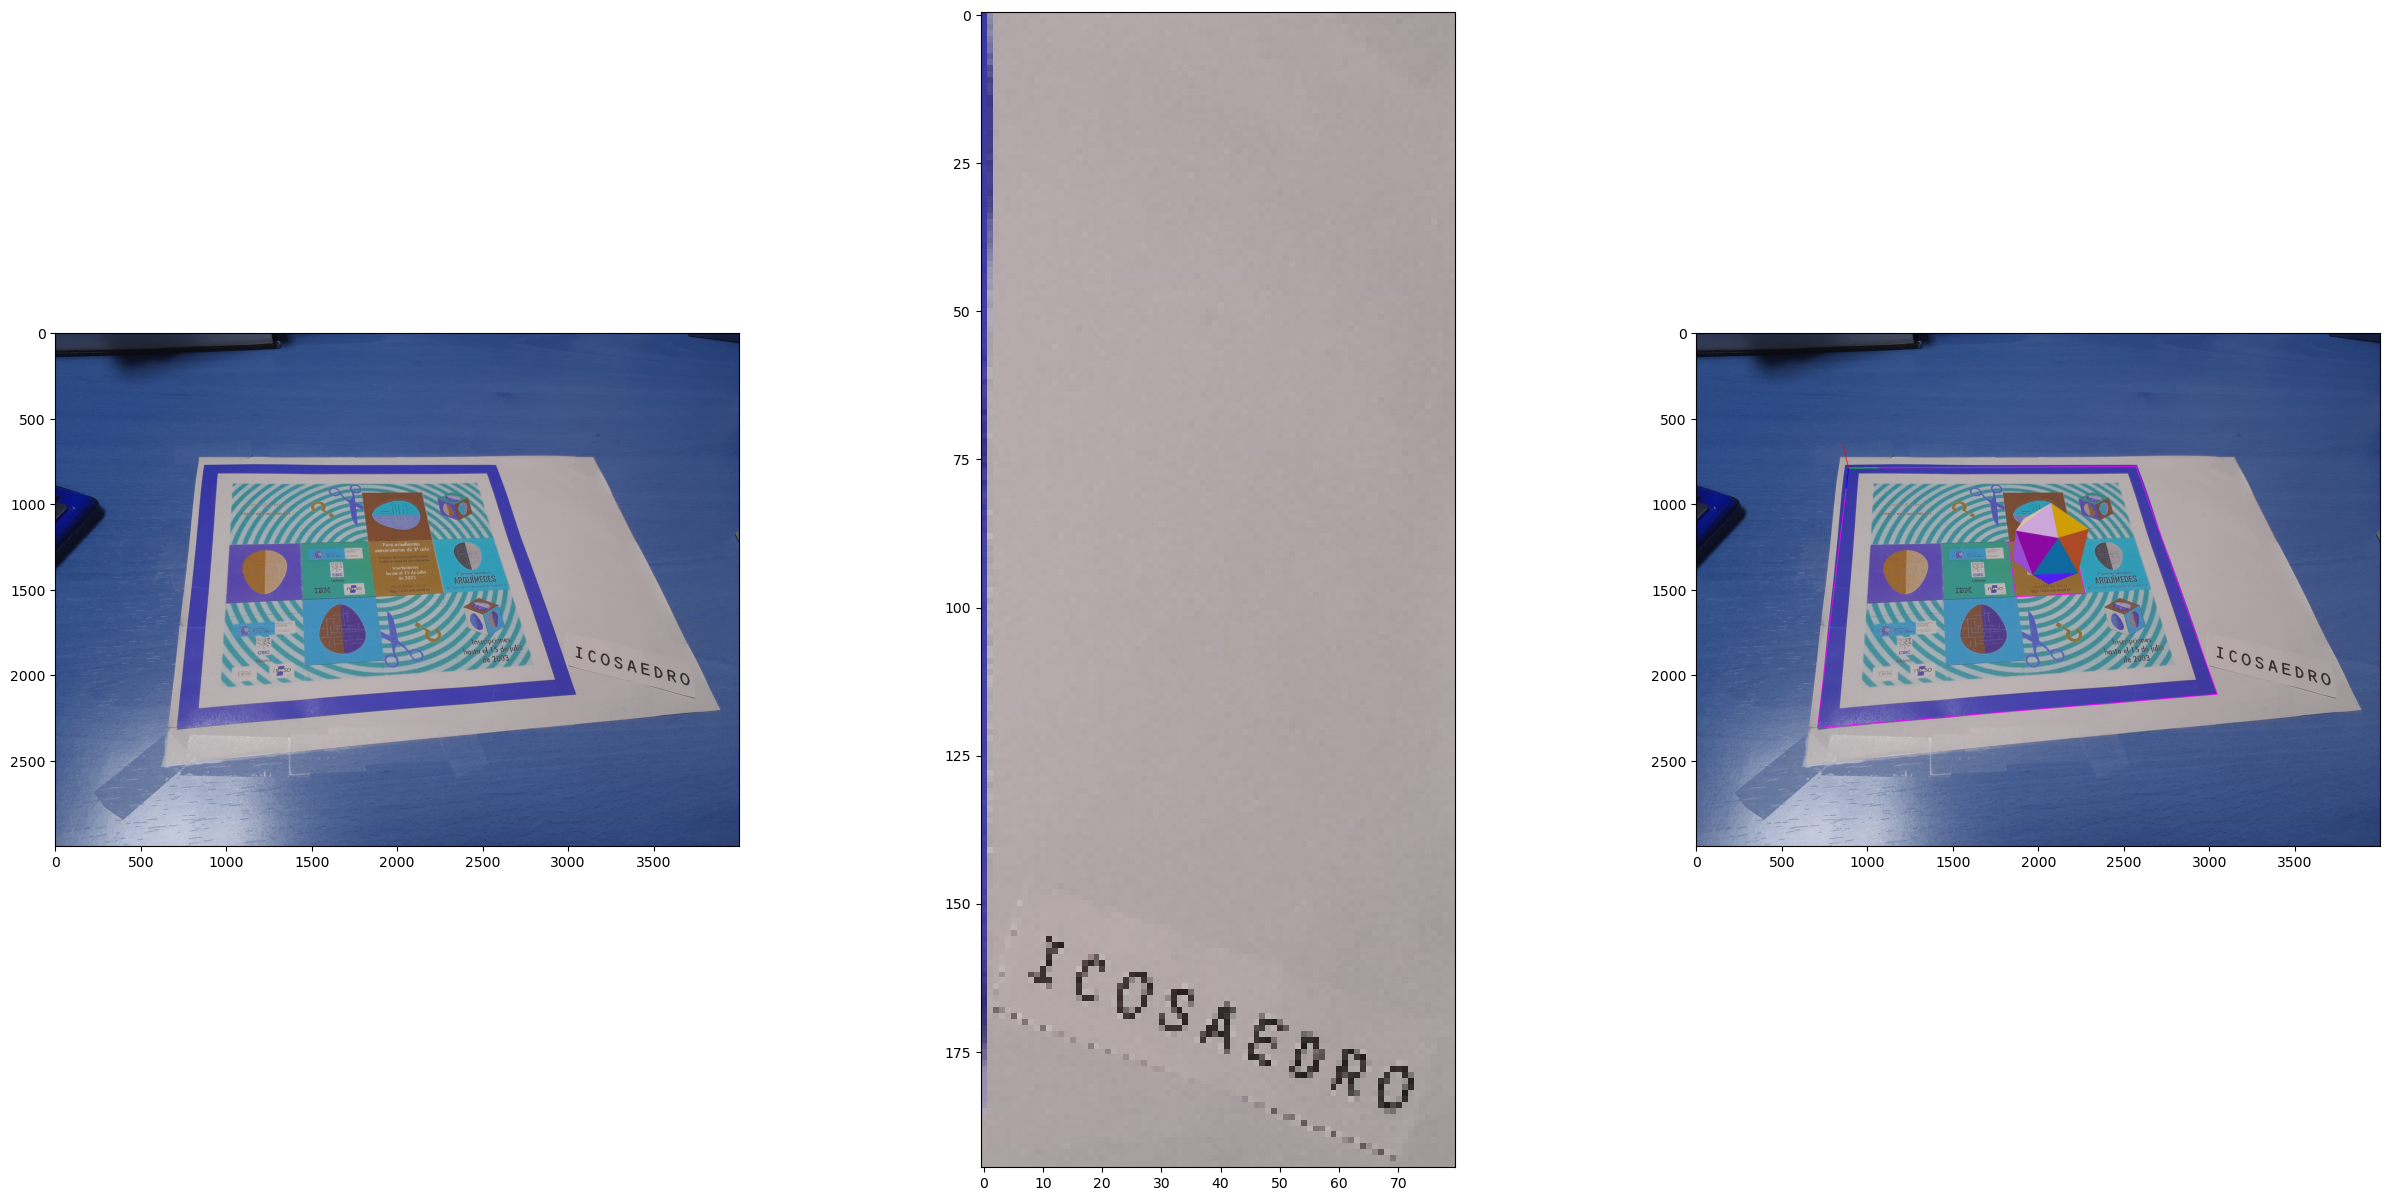

Cargando el modelo 3D 3d_models\tetraedro.obj


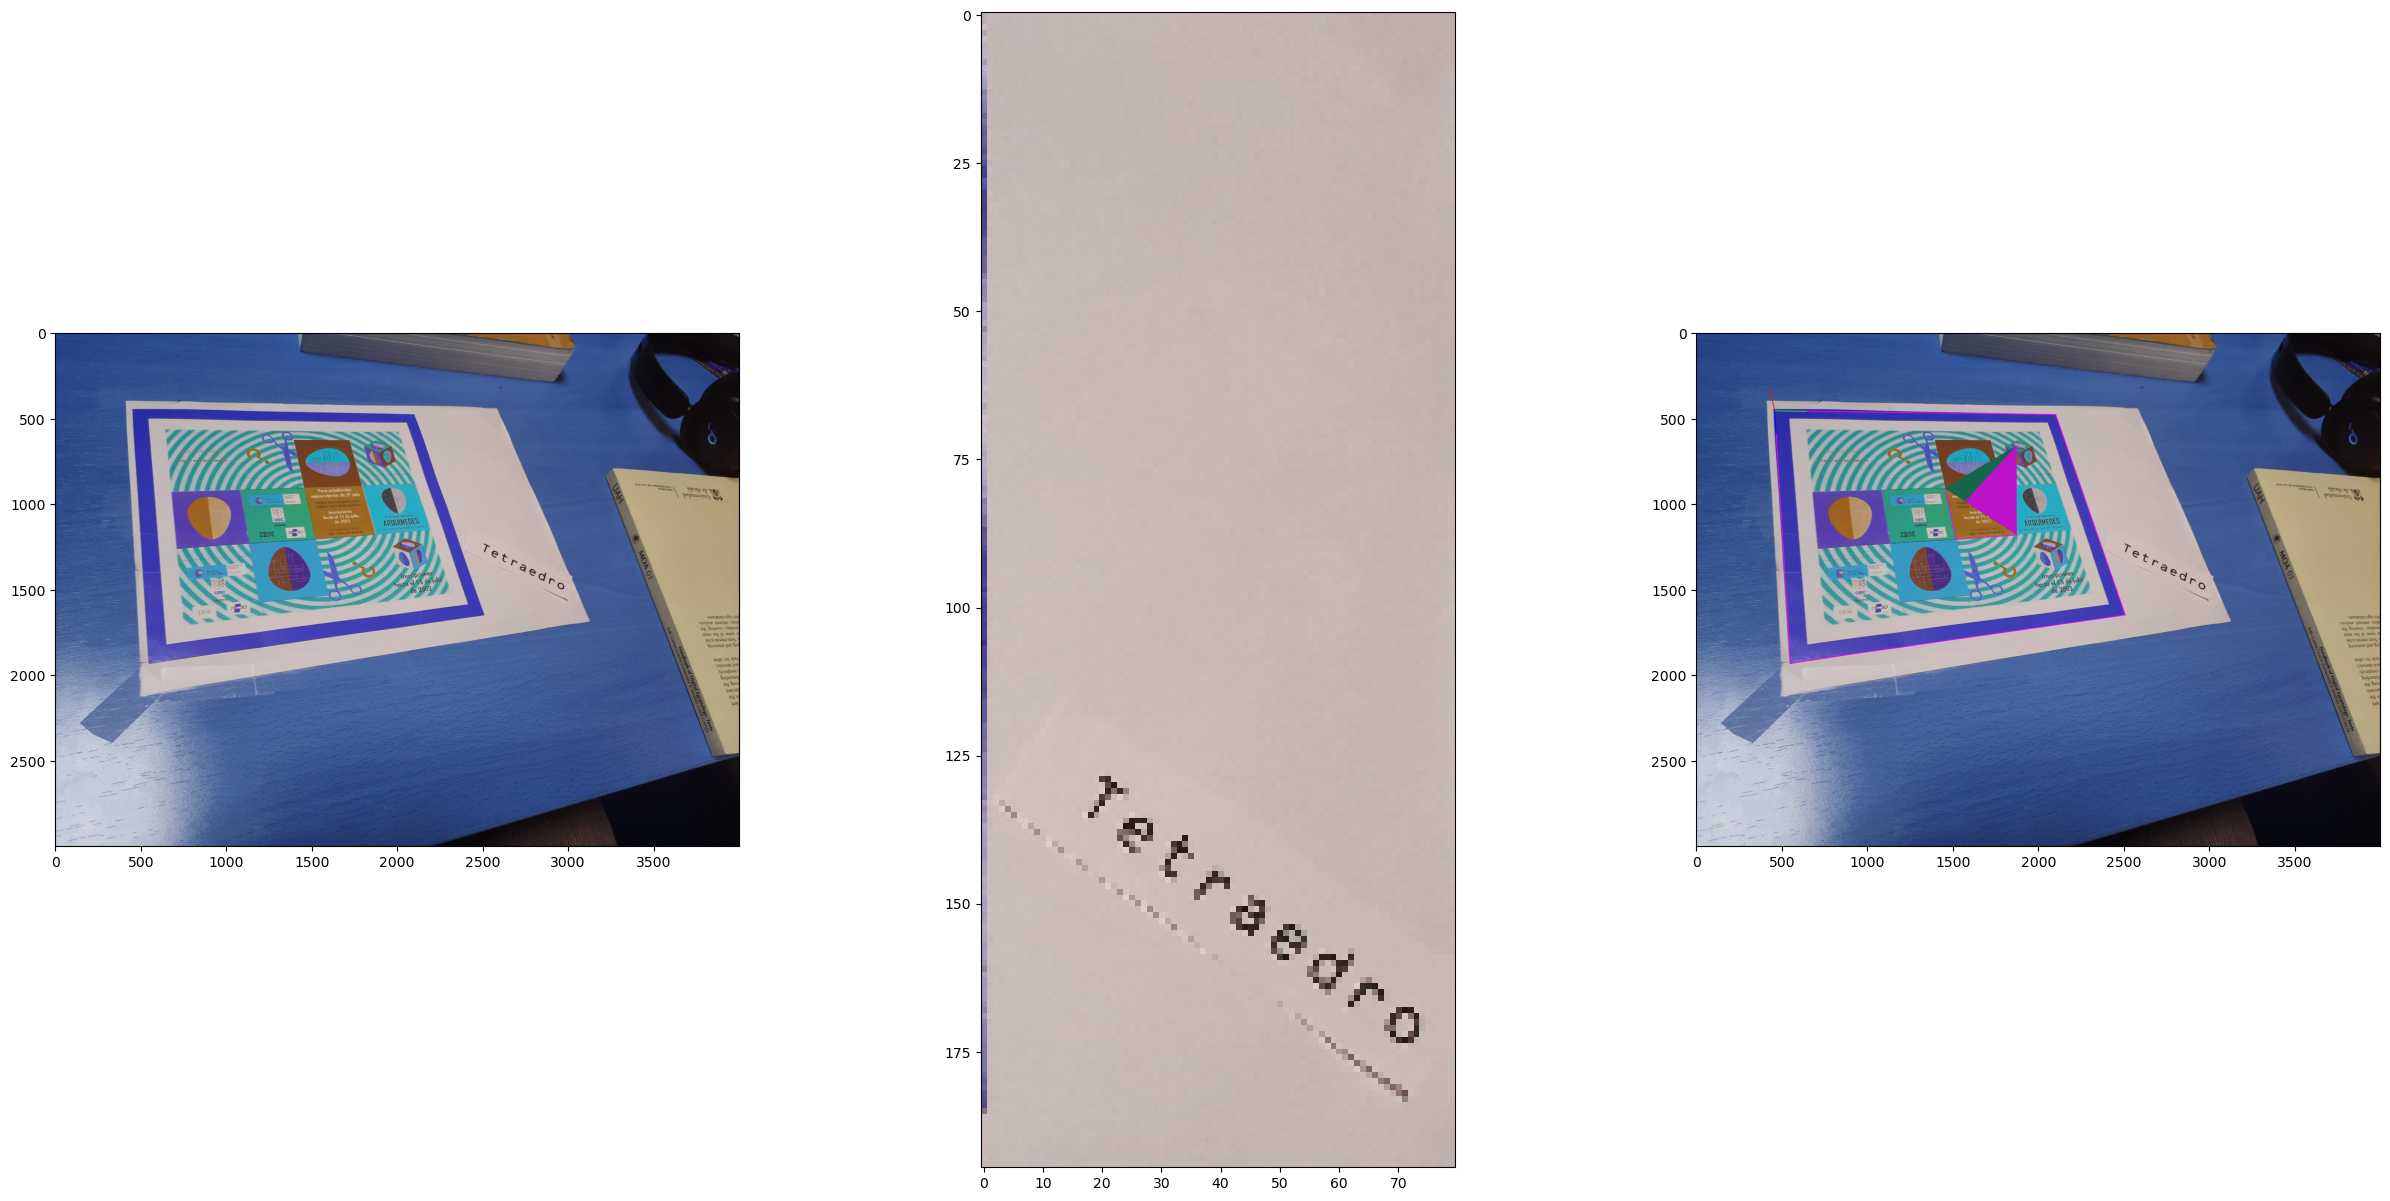

Cargando el modelo 3D 3d_models\cubo.obj


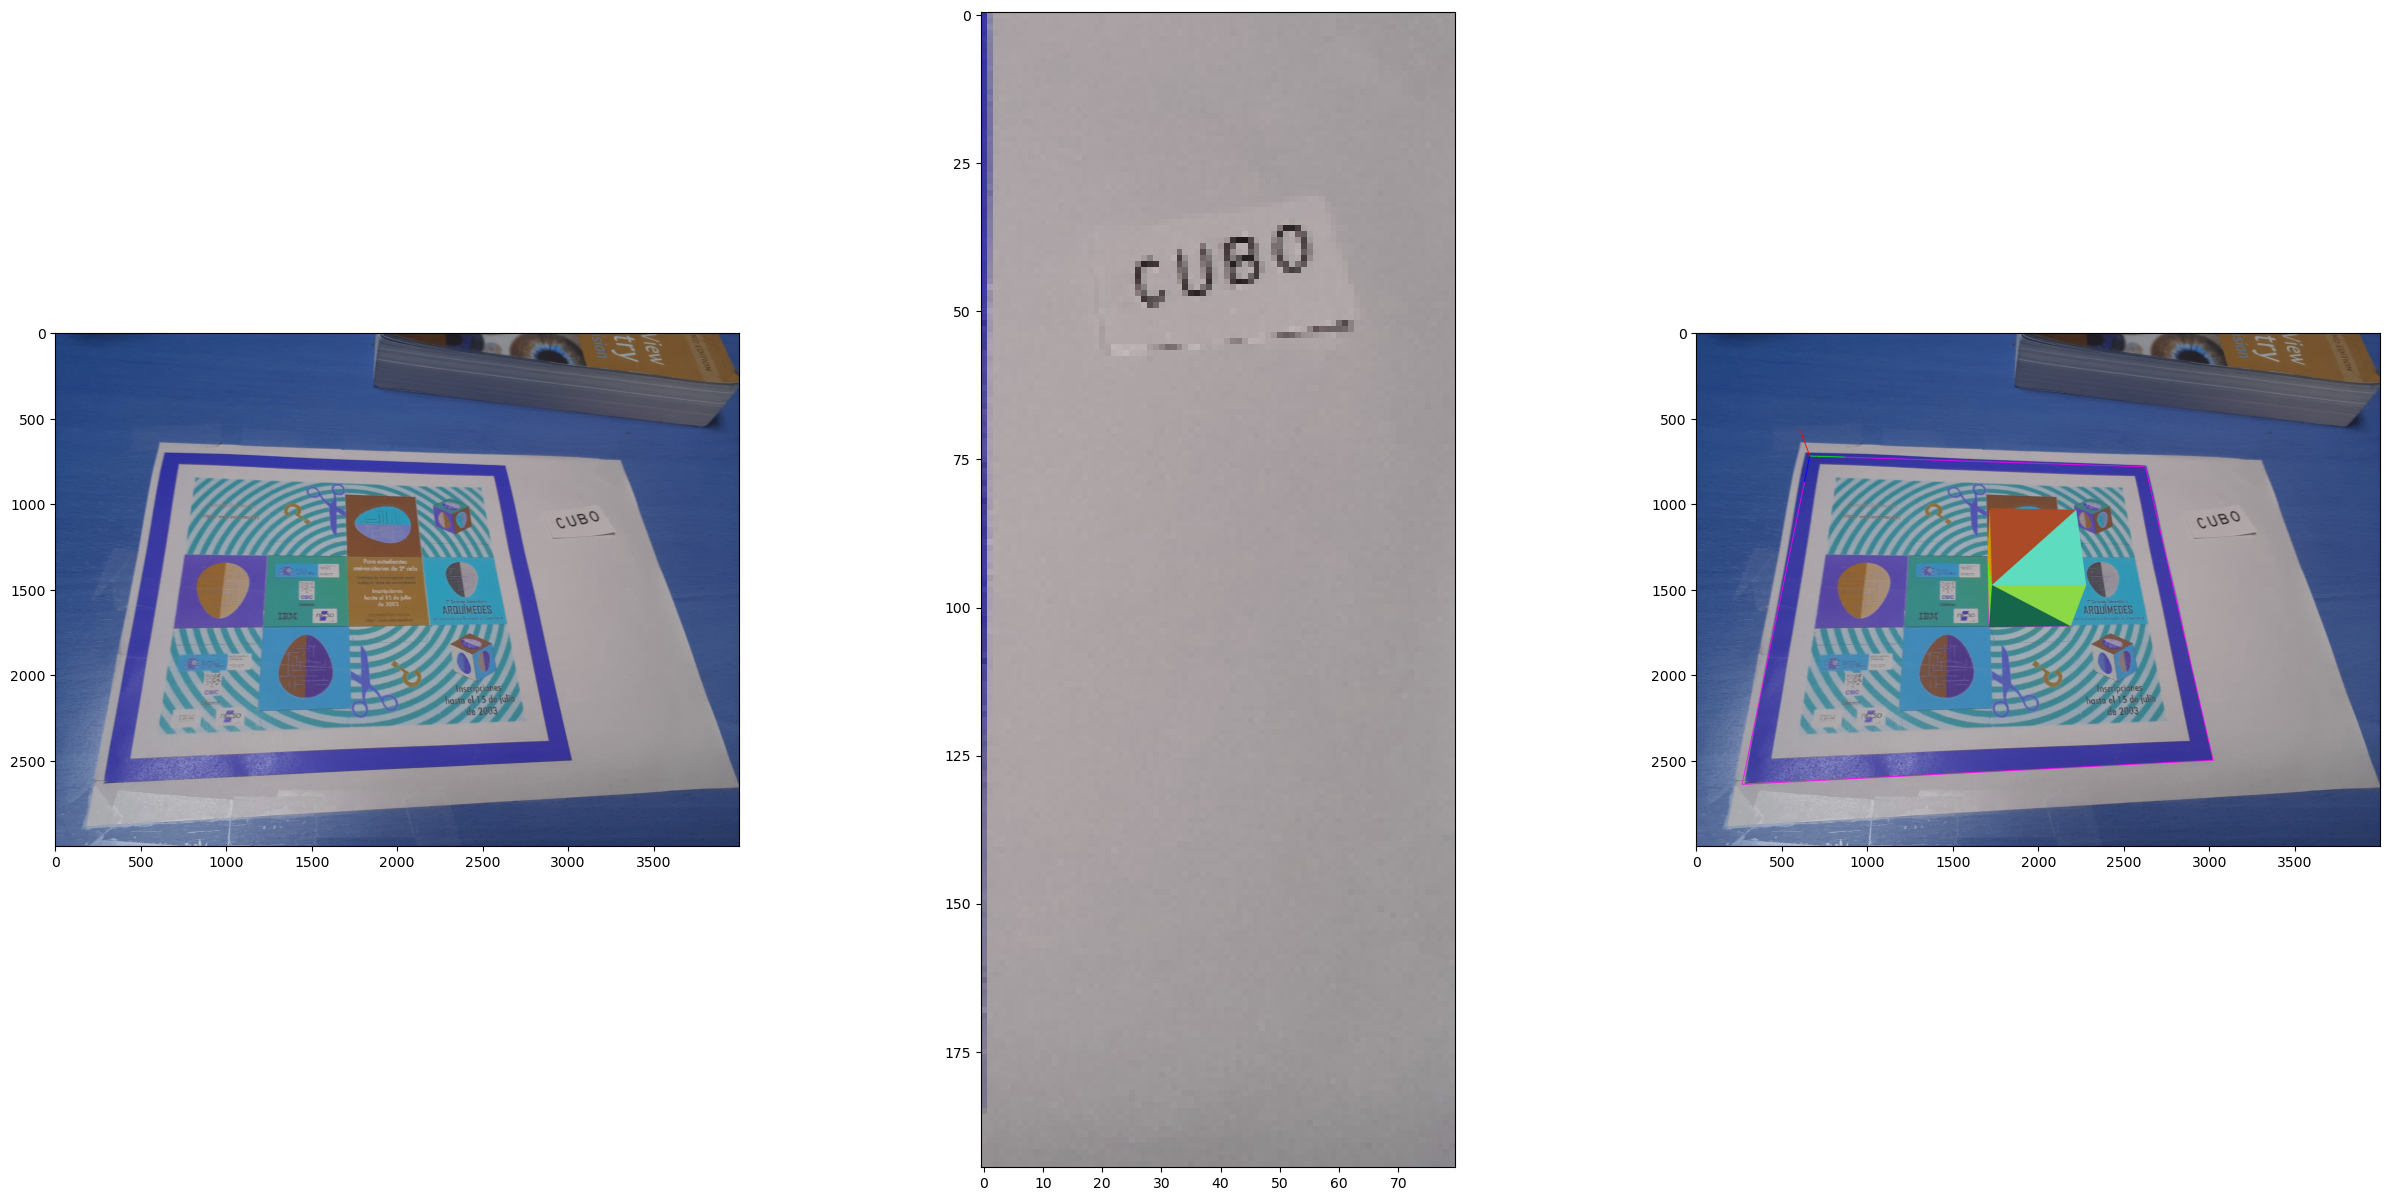

Cargando el modelo 3D 3d_models\dodecaedro.obj


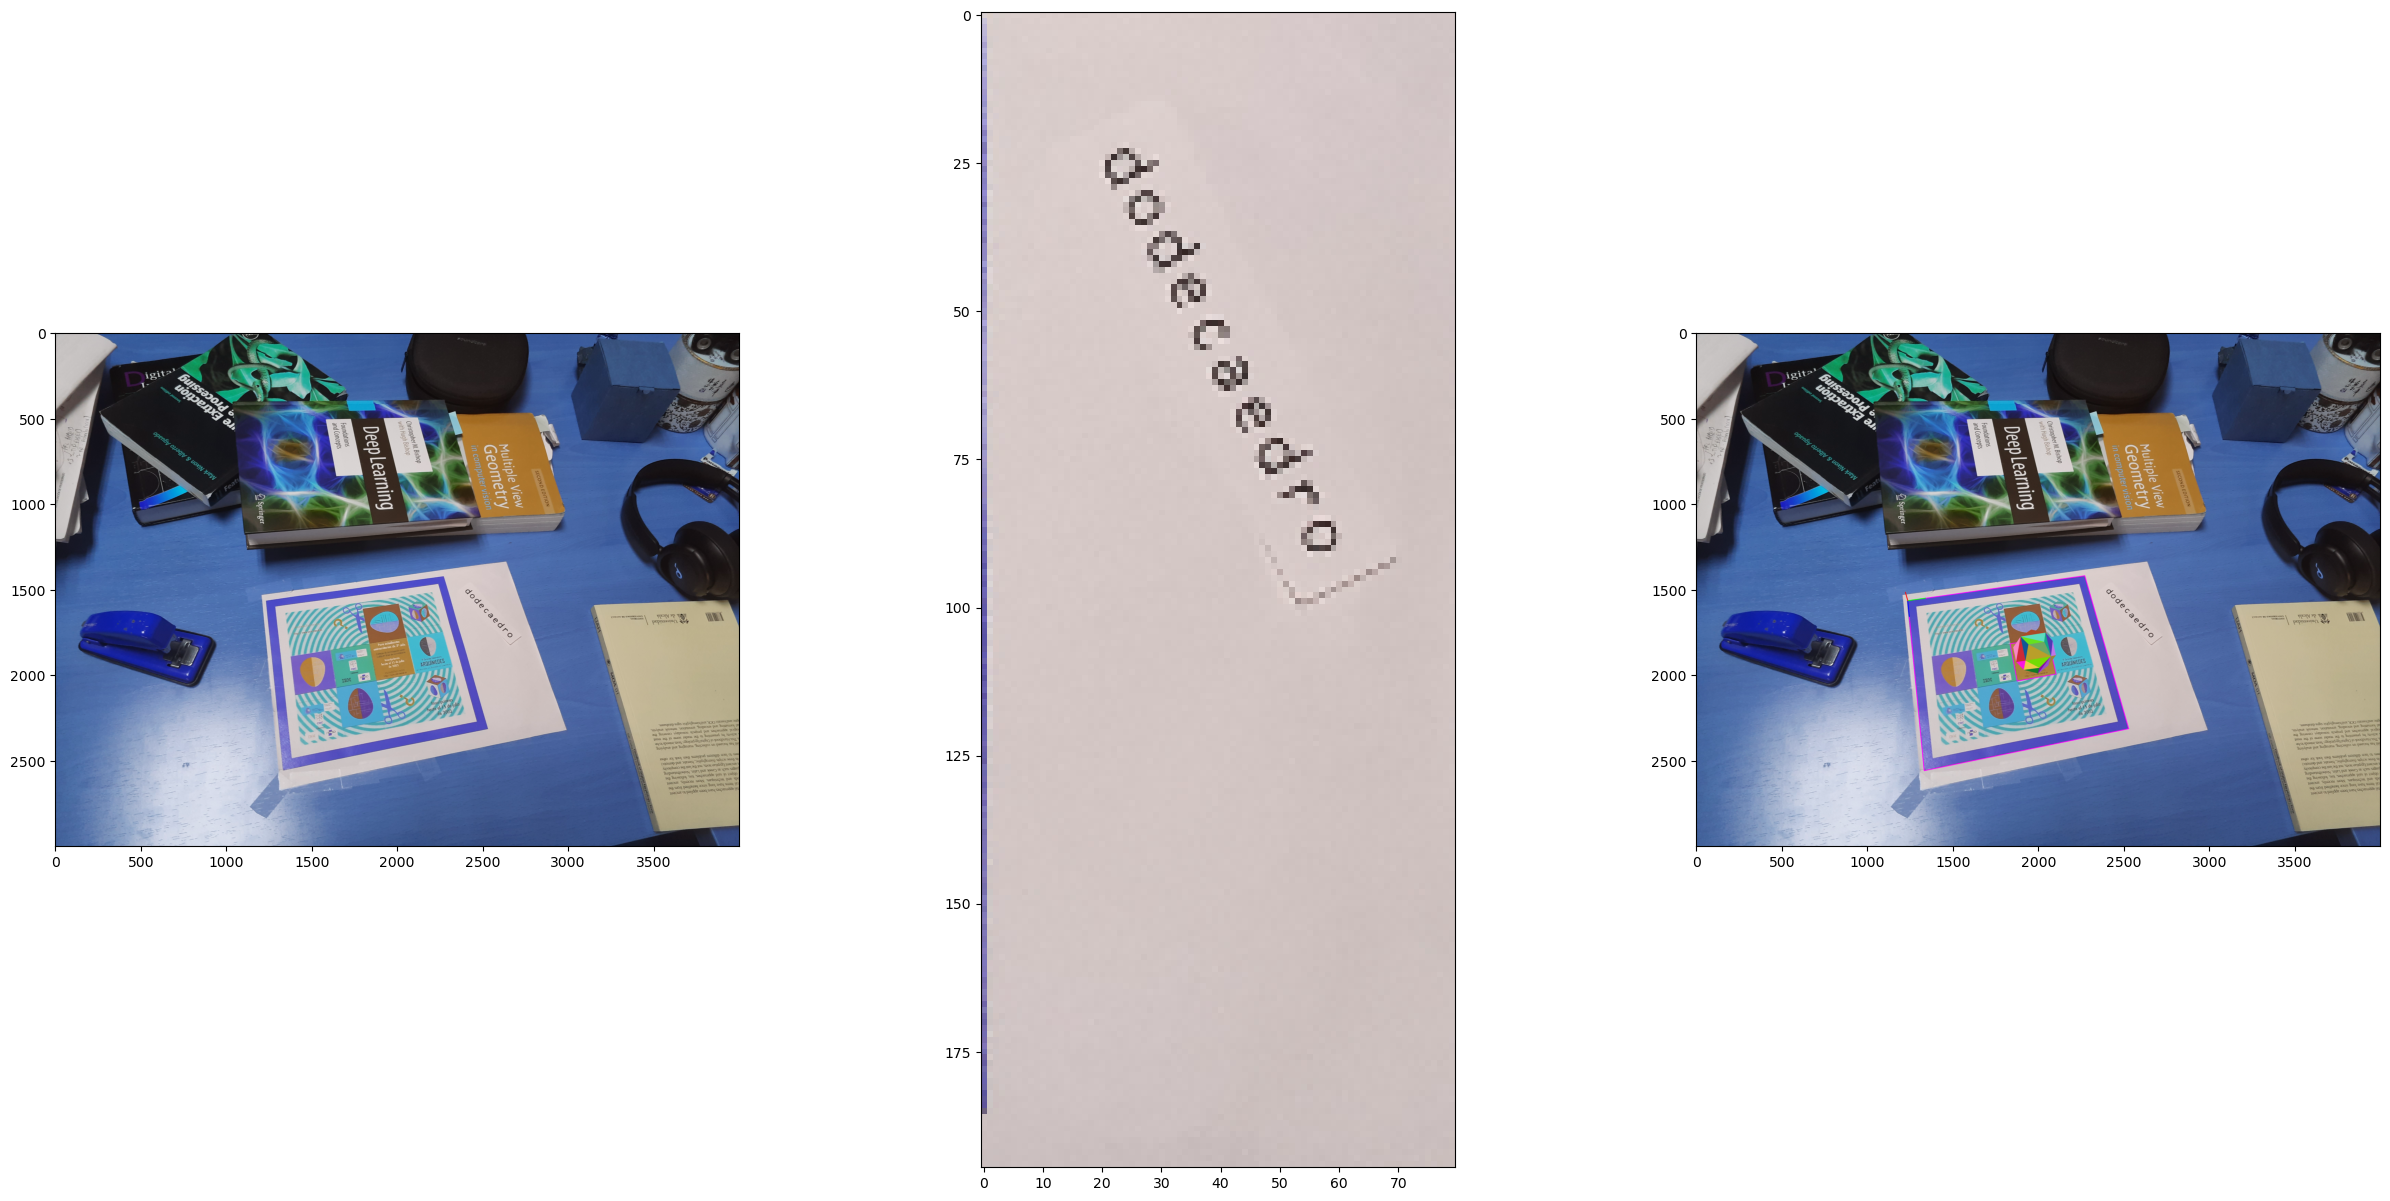

In [79]:
# Imágenes de Test_template_ocr_simple
show_figure(test_ocr_simple_path, figures_path, detector, matcher, clf, limit_pts_hom, pts_mm_hom, m3D, True)

In [78]:
# Imágenes de Test_template_ocr
show_figure(test_ocr_path, figures_path, detector, matcher, clf, limit_pts_hom, pts_mm_hom, m3D, False)

Cargando el modelo 3D 3d_models\cubo.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\cubo.obj
Cargando el modelo 3D 3d_models\cubo.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\octaedro.obj
Cargando el modelo 3D 3d_models\cubo.obj
Cargando el modelo 3D 3d_models\icosaedro.obj
Cargando el modelo 3D 3d_models\icosaedro.obj
Cargando el modelo 3D 3d_models\cubo.obj
Cargando el modelo 3D 3d_models\cubo.obj
Cargando el modelo 3D 3d_models\cubo.obj
Cargando el modelo 3D 3d_models\cubo.obj
Cargando el modelo 3D 3d_models\cubo.obj
Cargando el modelo 3D 3d_models\cubo.obj
Car